<a href="https://colab.research.google.com/github/touilnihel/nbody-simulation-numba/blob/main/nbody_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **N-Body Simulation with GPU Acceleration using Numba**
**The N-Body problem** is a classical physics simulation that models how multiple objects (e.g., planets, stars) move under Newtonian gravity. Each body exerts a force on every other body, and their velocities and positions update over time.

Since calculating gravitational interactions between all pairs of bodies has a **time complexity of O(N²)**, it can be computationally expensive for large numbers of particles. To speed this up, we use **GPU acceleration with Numba’s CUDA JIT compiler.**

This project implements a **GPU-accelerated version of the N-Body simulation**, optimizing the force computations and position updates to run efficiently on NVIDIA GPUs.

In [1]:
# Install numba if not already installed
!pip install numba matplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from numba import njit
from IPython.display import HTML

In [2]:
# Constants
G = 6.67430e-11  # Gravitational constant
# We'll scale this up for better visualization
G_SCALED = 1.0

In [3]:
class NBodySimulator:
    def __init__(self, n_bodies=100, use_numba=False):
        self.n_bodies = n_bodies
        self.use_numba = use_numba

        # Initialize random bodies
        self.initialize_bodies()

        # Store positions over time for trajectory visualization
        self.history = [self.positions.copy()]

        # Execution time tracking
        self.execution_times = []

    def initialize_bodies(self):
        # Random positions in a disk
        r = np.random.rand(self.n_bodies) * 10
        theta = np.random.rand(self.n_bodies) * 2 * np.pi

        self.positions = np.zeros((self.n_bodies, 2))
        self.positions[:, 0] = r * np.cos(theta)
        self.positions[:, 1] = r * np.sin(theta)

        # Random velocities, mostly tangential for orbit-like behavior
        self.velocities = np.zeros((self.n_bodies, 2))
        self.velocities[:, 0] = -np.sin(theta) * np.sqrt(G_SCALED / r) * 0.5
        self.velocities[:, 1] = np.cos(theta) * np.sqrt(G_SCALED / r) * 0.5

        # Random masses (with one dominant central mass)
        self.masses = np.random.rand(self.n_bodies) * 0.1 + 0.1
        # Add one massive central body
        self.positions[0] = [0, 0]  # Center position
        self.velocities[0] = [0, 0]  # No initial velocity
        self.masses[0] = 20.0  # Much larger mass

    def compute_forces_regular(self, positions, masses):
        """Regular Python implementation of force calculation"""
        n = len(positions)
        forces = np.zeros_like(positions)

        for i in range(n):
            for j in range(n):
                if i != j:
                    # Vector from body i to body j
                    r_vec = positions[j] - positions[i]
                    # Distance between bodies
                    r = np.linalg.norm(r_vec)
                    # Avoid division by very small numbers
                    if r < 0.1:
                        r = 0.1
                    # Force magnitude (F = G * m1 * m2 / r^2)
                    f_mag = G_SCALED * masses[i] * masses[j] / (r * r)
                    # Force vector
                    forces[i] += f_mag * r_vec / r

        return forces

    @staticmethod
    @njit
    def compute_forces_numba(positions, masses):
        """Numba-optimized implementation of force calculation"""
        n = len(positions)
        forces = np.zeros_like(positions)

        for i in range(n):
            for j in range(n):
                if i != j:
                    # Vector from body i to body j
                    r_vec = positions[j] - positions[i]
                    # Distance between bodies
                    r = np.sqrt(r_vec[0]**2 + r_vec[1]**2)
                    # Avoid division by very small numbers
                    if r < 0.1:
                        r = 0.1
                    # Force magnitude (F = G * m1 * m2 / r^2)
                    f_mag = G_SCALED * masses[i] * masses[j] / (r * r)
                    # Force vector
                    forces[i, 0] += f_mag * r_vec[0] / r
                    forces[i, 1] += f_mag * r_vec[1] / r

        return forces

    def update(self, dt=0.01):
        """Update positions and velocities based on forces"""
        start_time = time.time()

        if self.use_numba:
            forces = self.compute_forces_numba(self.positions, self.masses)
        else:
            forces = self.compute_forces_regular(self.positions, self.masses)

        # Update velocities (a = F/m)
        accelerations = forces / self.masses[:, np.newaxis]
        self.velocities += accelerations * dt

        # Update positions
        self.positions += self.velocities * dt

        # Store position for trajectory
        self.history.append(self.positions.copy())

        end_time = time.time()
        self.execution_times.append(end_time - start_time)

    def simulate(self, steps=100):
        """Run simulation for a specified number of steps"""
        for _ in range(steps):
            self.update()

        avg_time = np.mean(self.execution_times)
        print(f"Average execution time per step: {avg_time:.6f} seconds")
        return avg_time

    def visualize_static(self):
        """Visualize the current state of the system"""
        plt.figure(figsize=(10, 10))

        # Plot the bodies
        sizes = self.masses * 50  # Scale the sizes based on masses
        plt.scatter(self.positions[:, 0], self.positions[:, 1], s=sizes, c=np.arange(len(self.positions)), cmap='viridis')

        # Plot the trajectory of each body
        if len(self.history) > 1:
            history_array = np.array(self.history)
            for i in range(min(10, self.n_bodies)):  # Plot only a few trajectories for clarity
                plt.plot(history_array[:, i, 0], history_array[:, i, 1], 'k-', alpha=0.2)

        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.title('N-Body Simulation')
        plt.grid(True, alpha=0.3)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

# Function to create a simple static animation without FuncAnimation
def create_simple_animation(simulator, frames=100, dt=0.01):
    """
    Create a simple animation by generating a series of plots and returning HTML
    This is more reliable in Colab than using FuncAnimation
    """
    from IPython.display import HTML
    import matplotlib.pyplot as plt
    from base64 import b64encode
    import io

    plt.ioff()  # Turn off interactive mode

    # Create a list to store encoded images
    encoded_images = []

    # Set figure size and limits
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title('N-Body Simulation')

    # Create frames
    for i in range(frames):
        ax.clear()
        ax.set_xlim(-15, 15)
        ax.set_ylim(-15, 15)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'N-Body Simulation - Frame {i+1}')

        # Update simulation
        simulator.update(dt)

        # Plot current positions
        sizes = simulator.masses * 50
        ax.scatter(simulator.positions[:, 0], simulator.positions[:, 1],
                  s=sizes, c=np.arange(simulator.n_bodies), cmap='viridis')

        # Save figure to a byte buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Encode the image
        data = b64encode(buf.getvalue()).decode('ascii')
        encoded_images.append(f'<img src="data:image/png;base64,{data}">')

    plt.close(fig)
    plt.ion()  # Turn on interactive mode again

    # Create HTML with JavaScript to display frames sequentially
    html = '''
    <div id="animation" style="display: flex; justify-content: center;">
        <img id="animationImage" src="">
    </div>
    <div style="display: flex; justify-content: center; margin-top: 10px;">
        <button id="playPauseBtn" onclick="togglePlayPause()">Pause</button>
        <div style="margin: 0 10px;">
            <input type="range" id="frameSlider" min="0" max="{max}" value="0"
                   style="width: 300px;" oninput="updateFrame(this.value)">
        </div>
        <span id="frameCounter">Frame: 1/{total}</span>
    </div>

    <script>
        var frames = {frames};
        var currentFrame = 0;
        var playing = true;
        var frameRate = 10; // frames per second
        var interval;

        function updateFrame(frame) {{
            frame = parseInt(frame);
            currentFrame = frame;
            document.getElementById('animationImage').src = frames[frame].split('"')[1];
            document.getElementById('frameCounter').textContent = 'Frame: ' + (frame + 1) + '/{total}';
            document.getElementById('frameSlider').value = frame;
        }}

        function nextFrame() {{
            currentFrame = (currentFrame + 1) % frames.length;
            updateFrame(currentFrame);
        }}

        function togglePlayPause() {{
            playing = !playing;
            document.getElementById('playPauseBtn').textContent = playing ? 'Pause' : 'Play';
            if (playing) {{
                interval = setInterval(nextFrame, 1000 / frameRate);
            }} else {{
                clearInterval(interval);
            }}
        }}

        // Start animation
        updateFrame(0);
        interval = setInterval(nextFrame, 1000 / frameRate);
    </script>
    '''.format(frames=encoded_images, max=len(encoded_images)-1, total=len(encoded_images))

    return HTML(html)


Creating simulator with 50 bodies
Running simulation for 100 steps
Average execution time per step: 0.052545 seconds
Creating static visualization


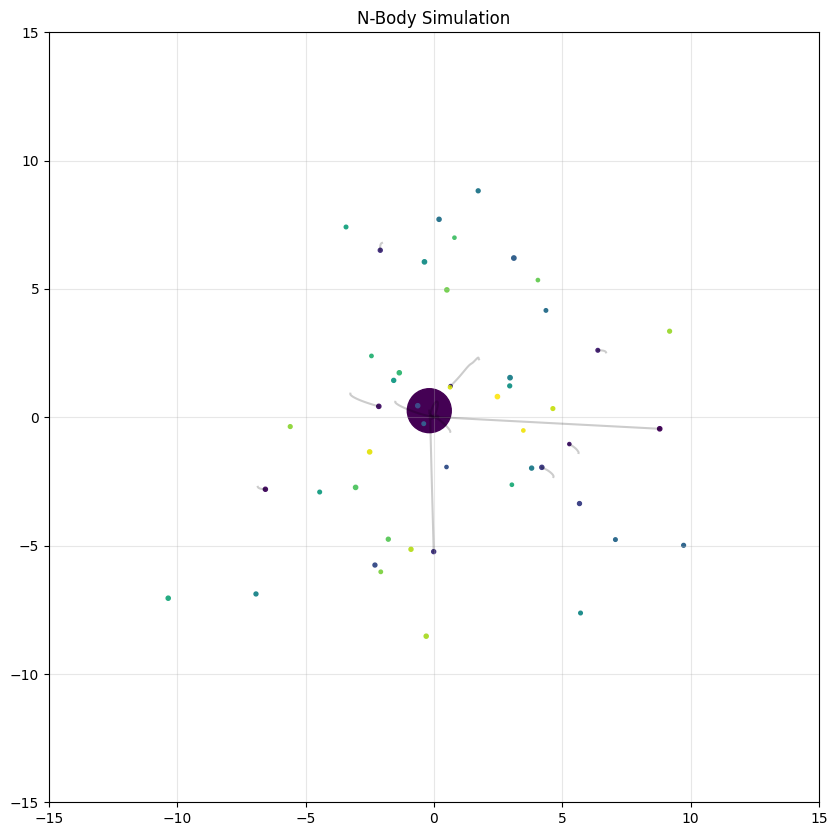

Creating animation with 50 frames
This may take a moment...



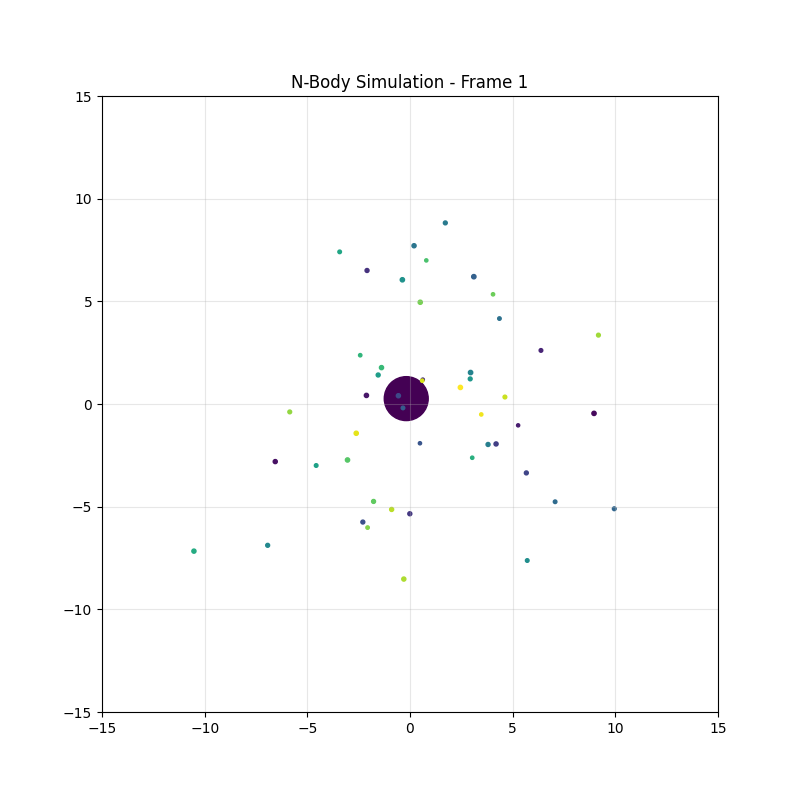
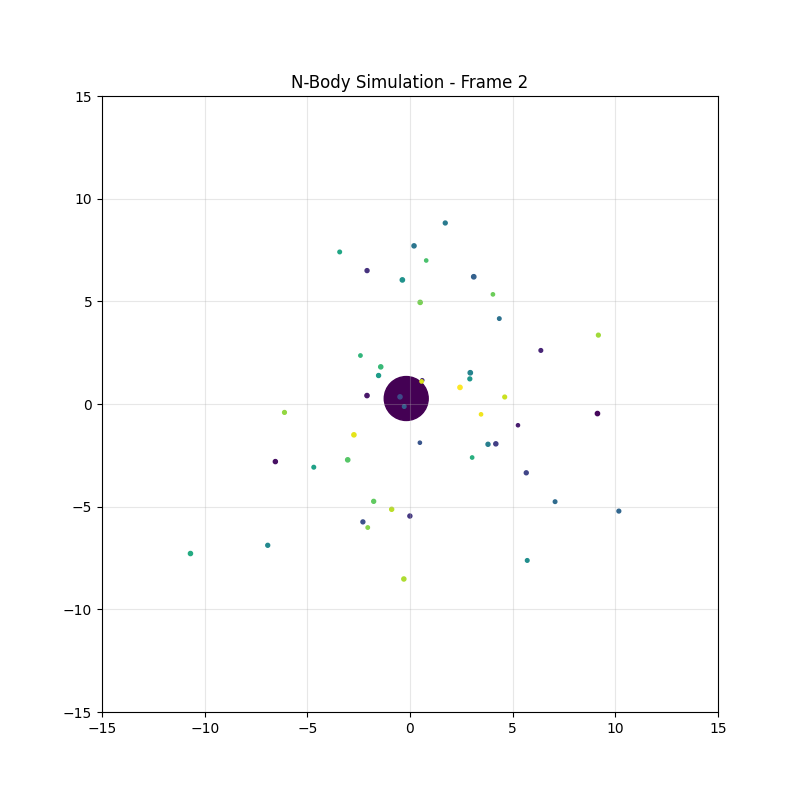
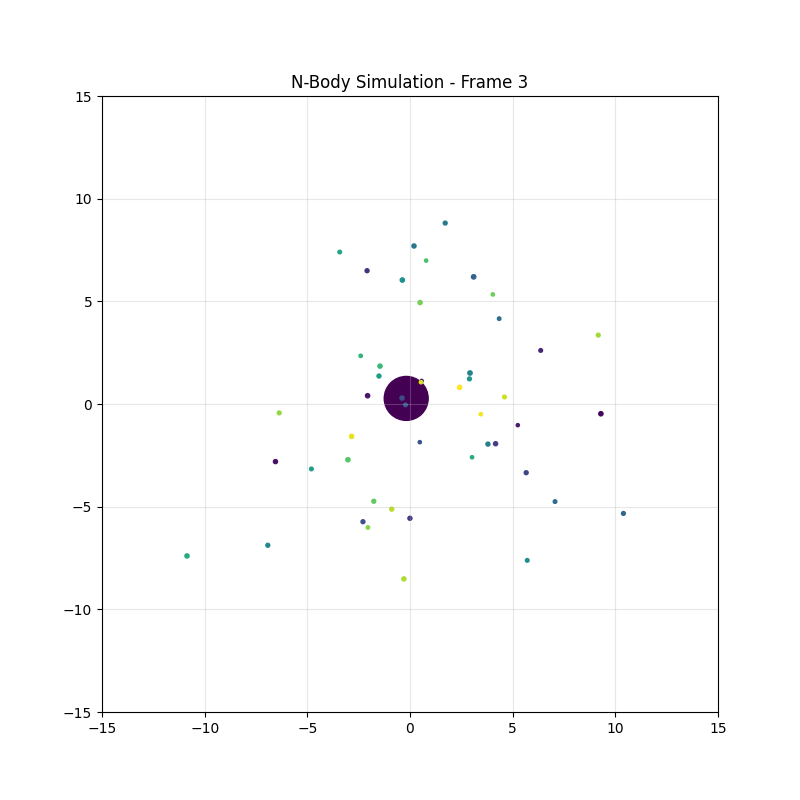
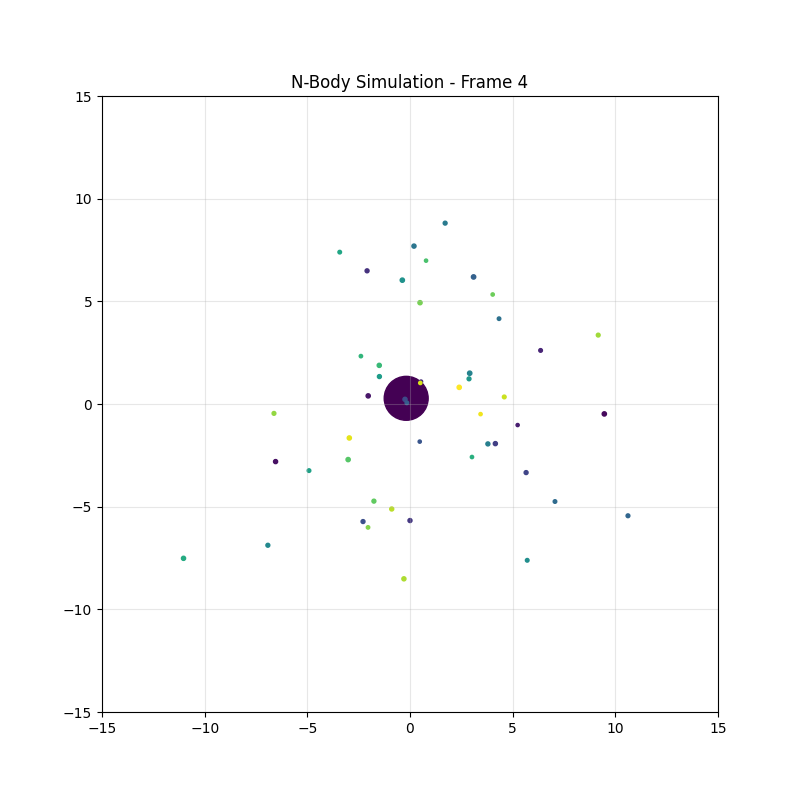
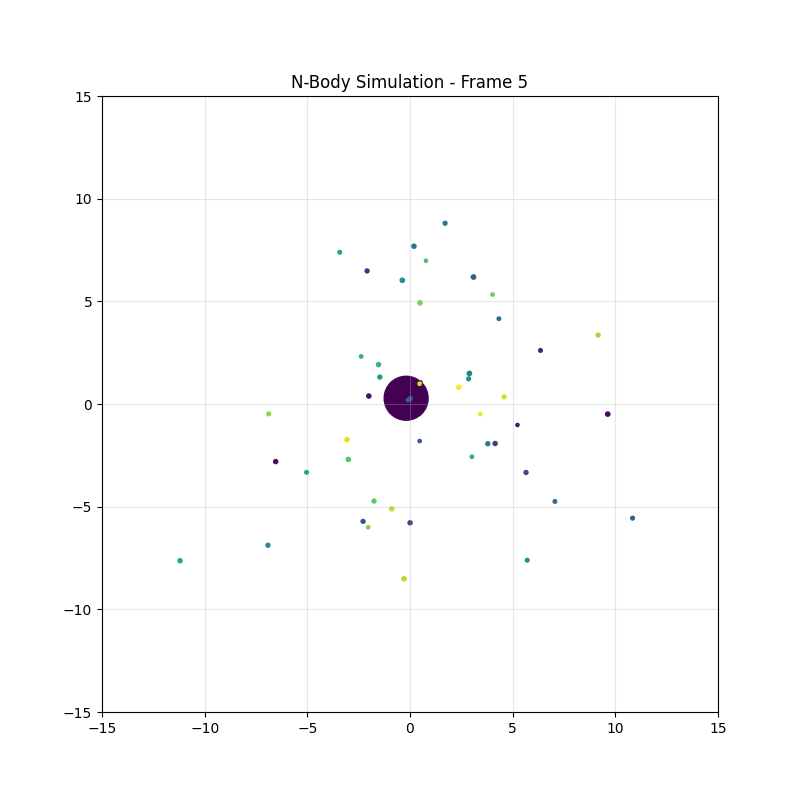
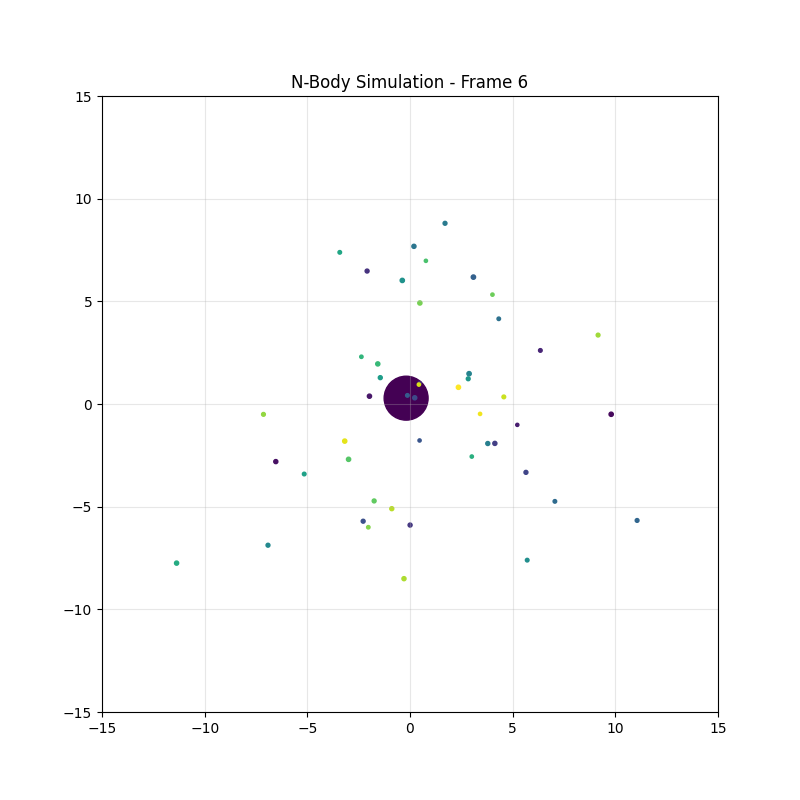
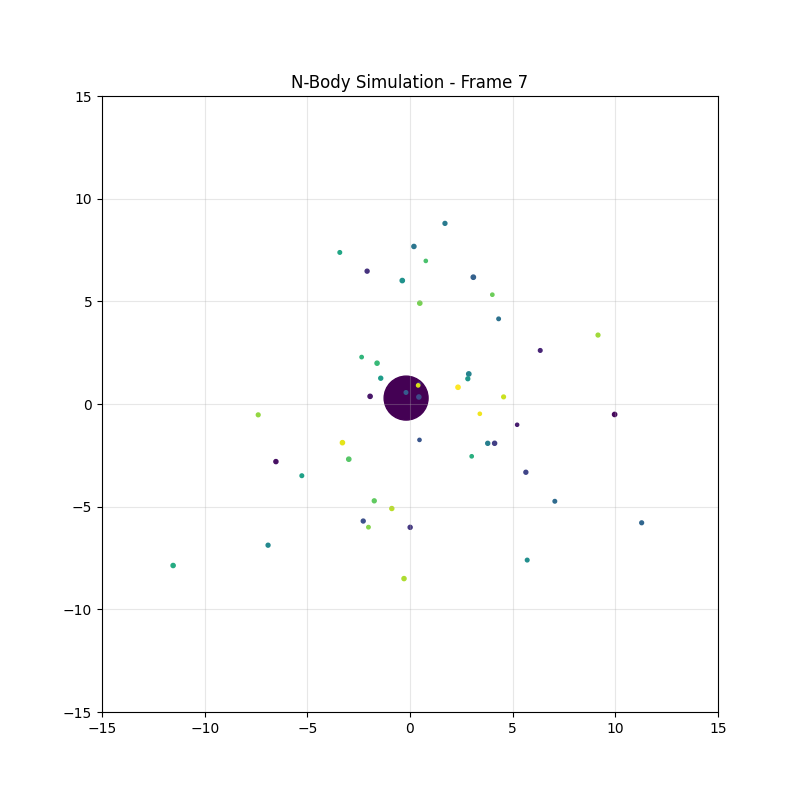
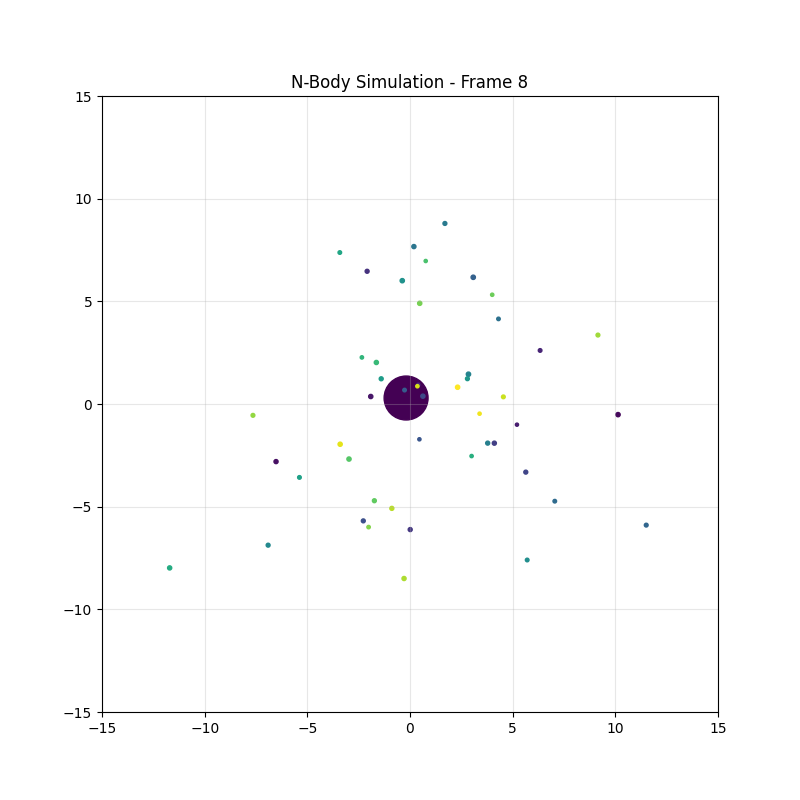
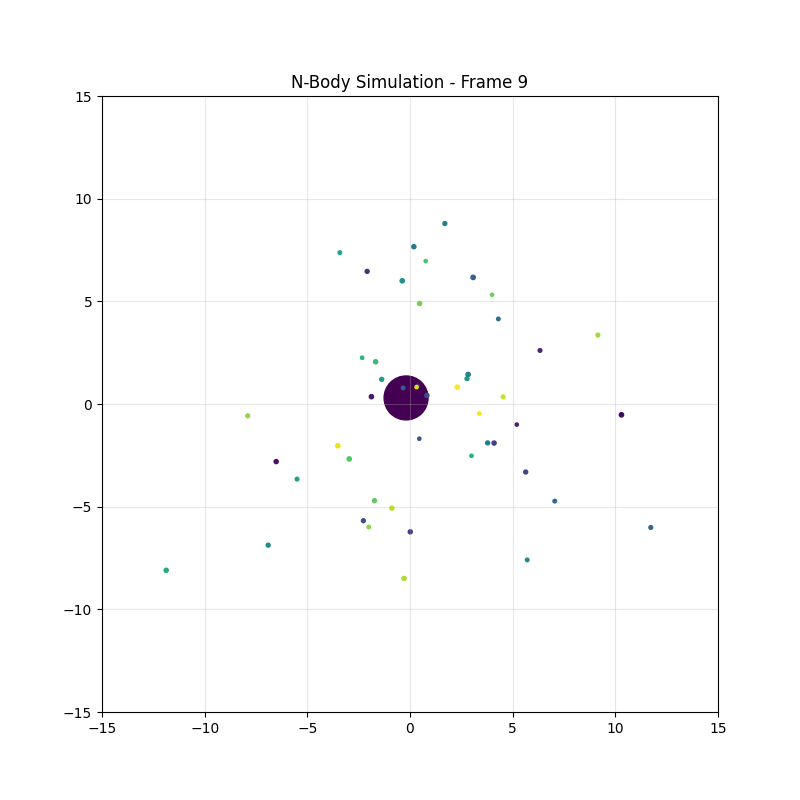
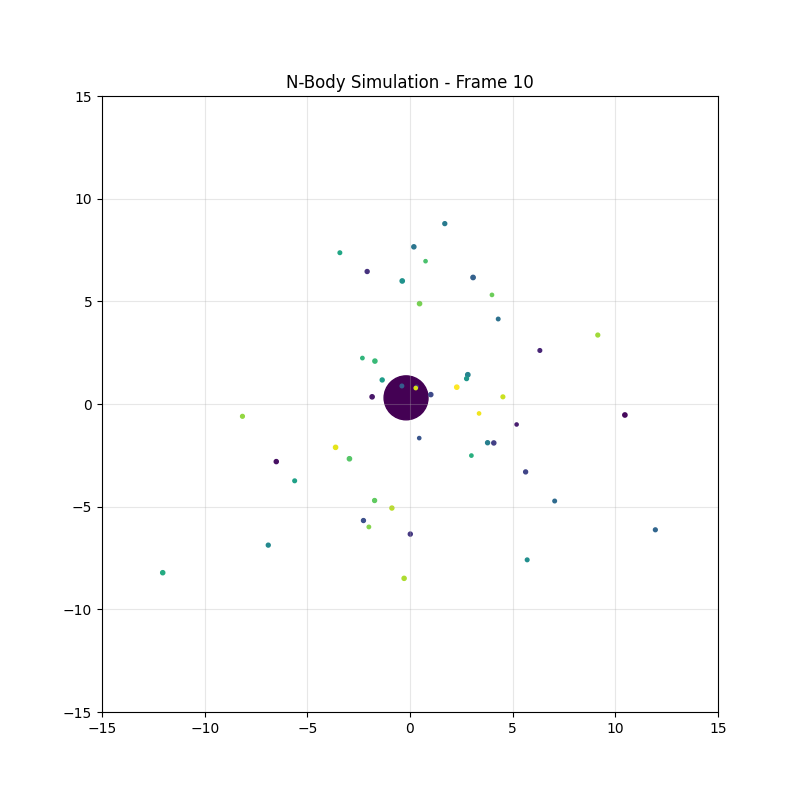
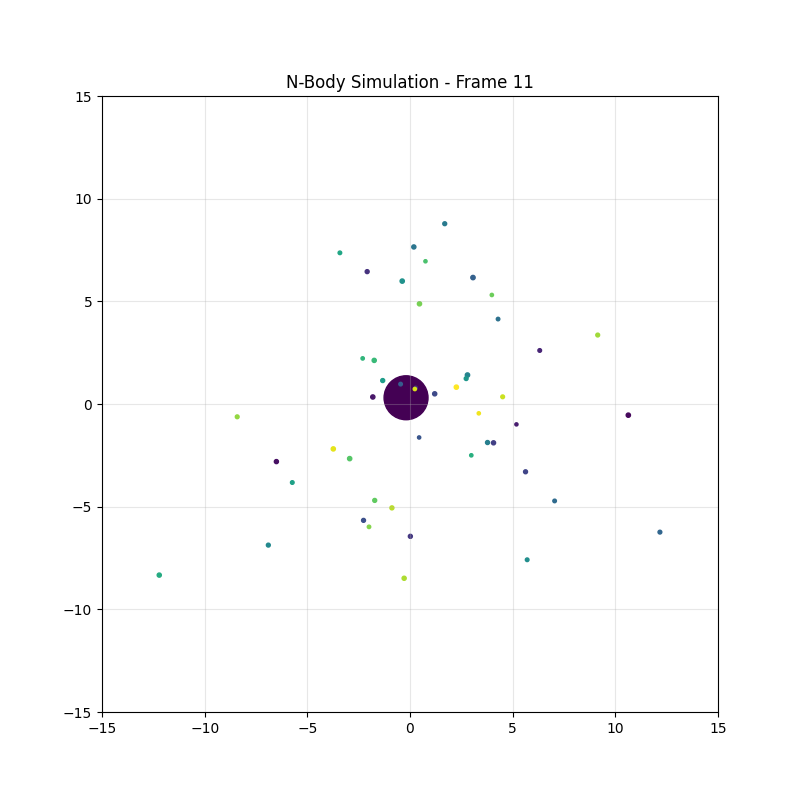
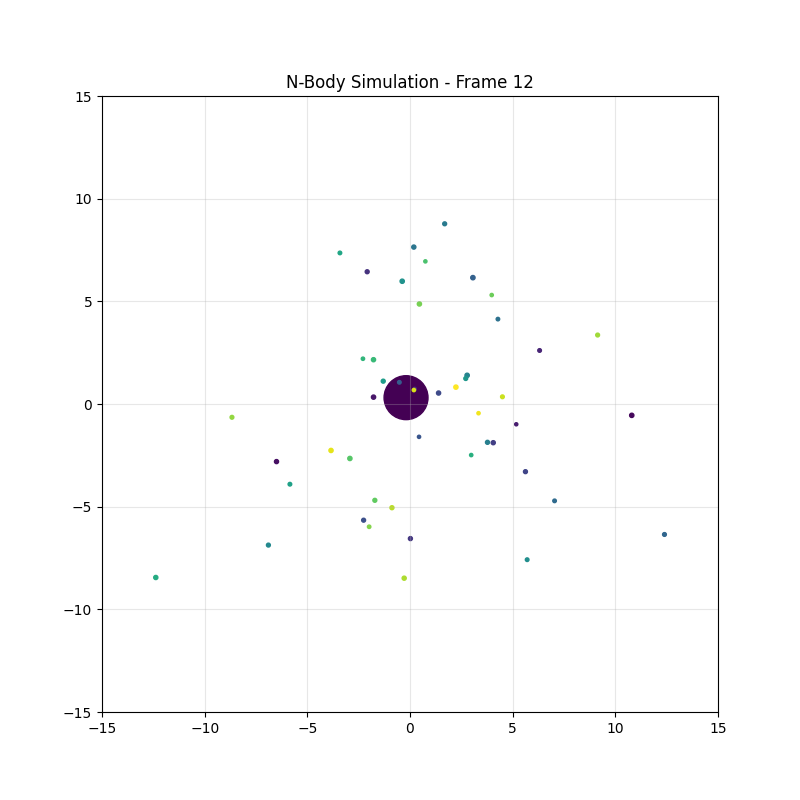
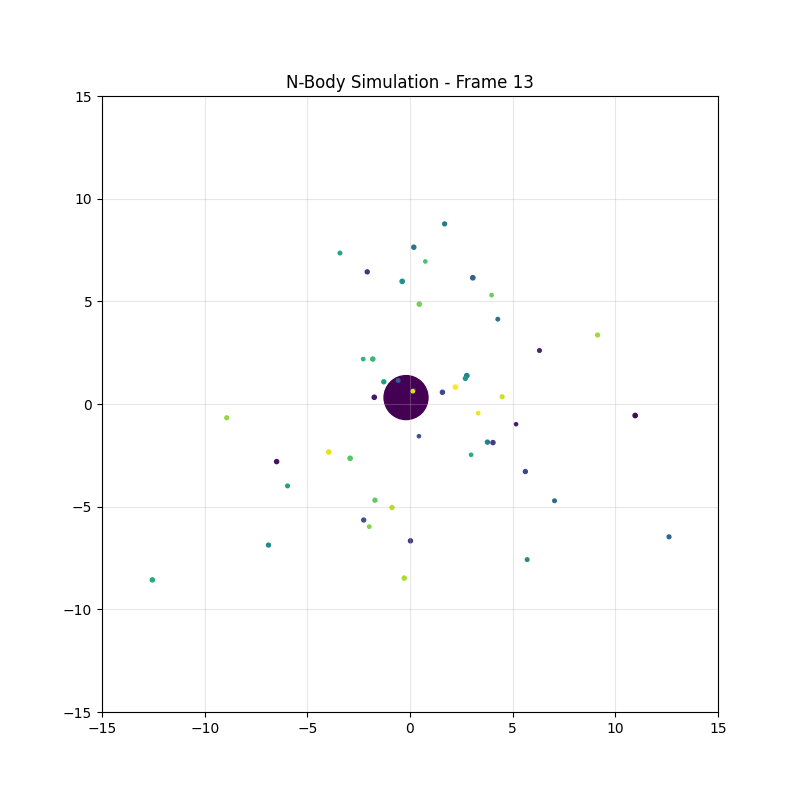
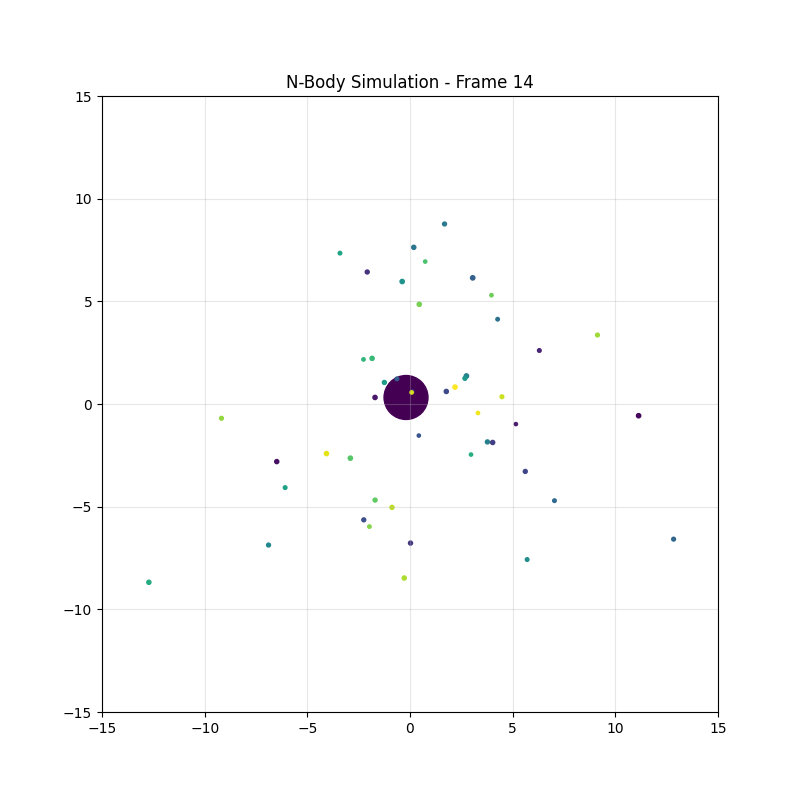
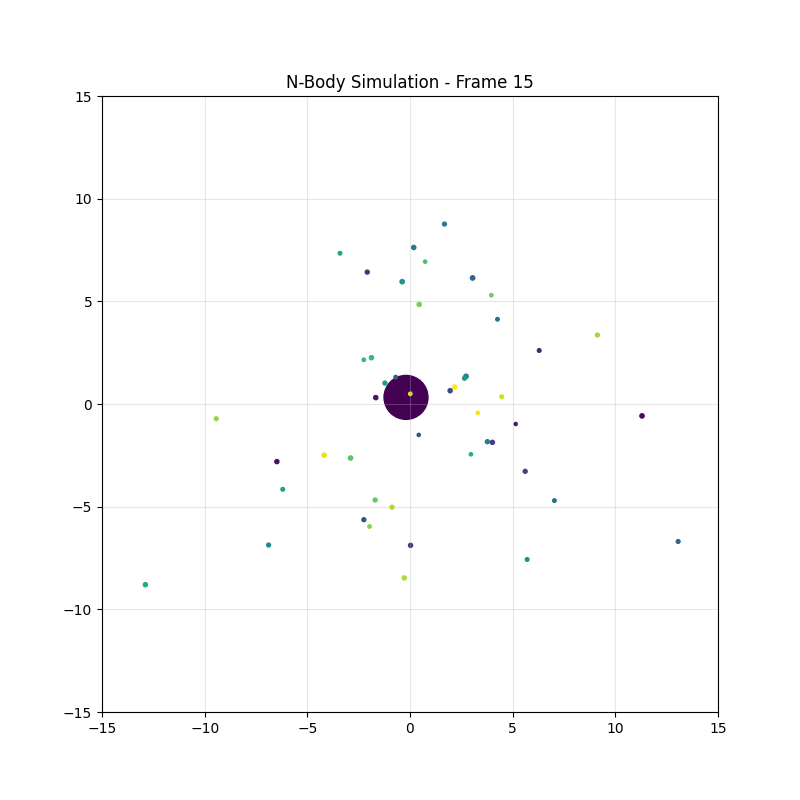
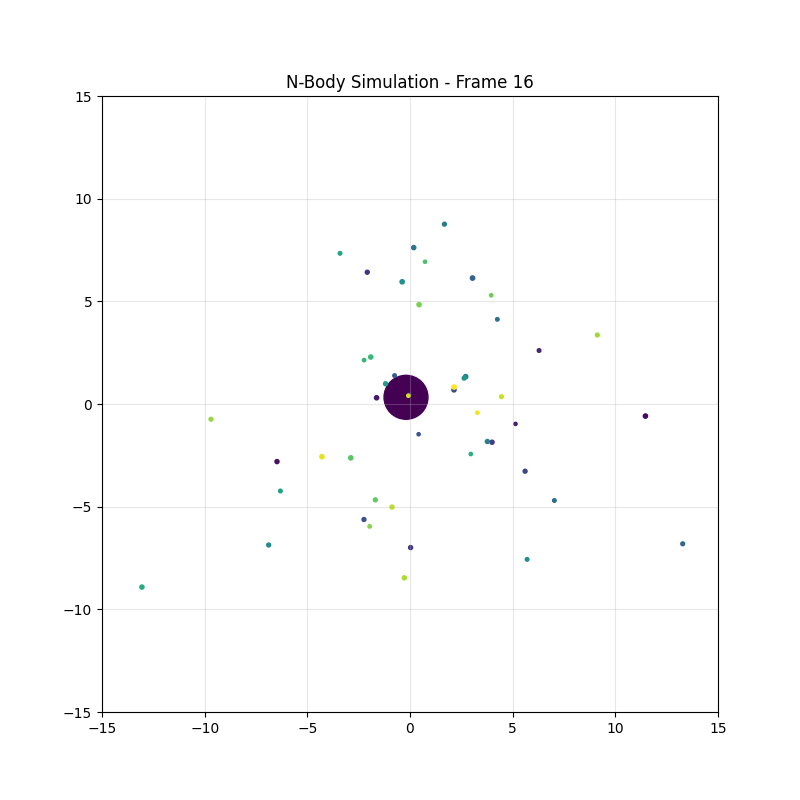
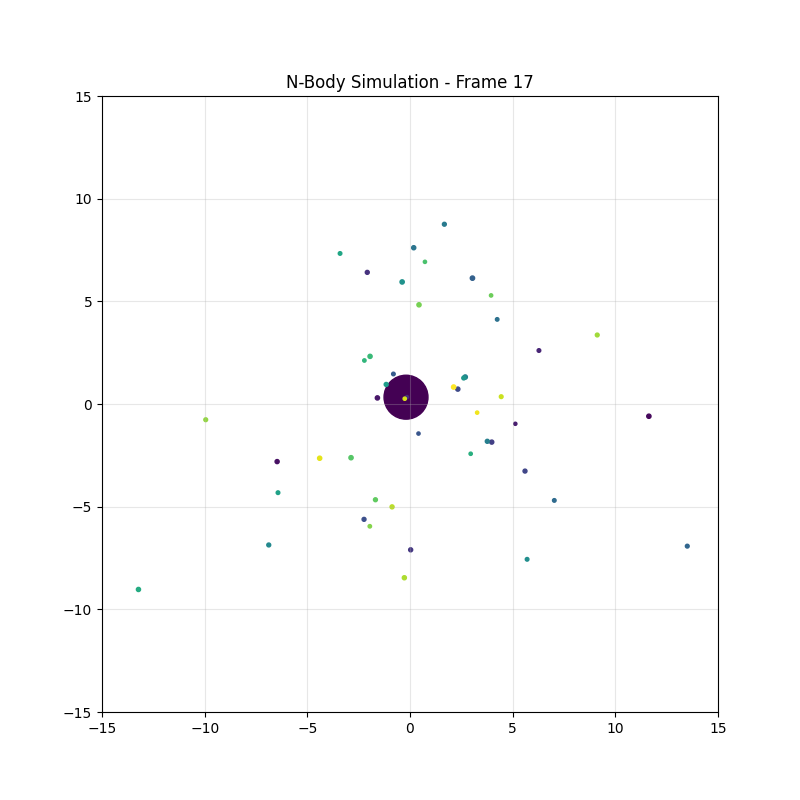
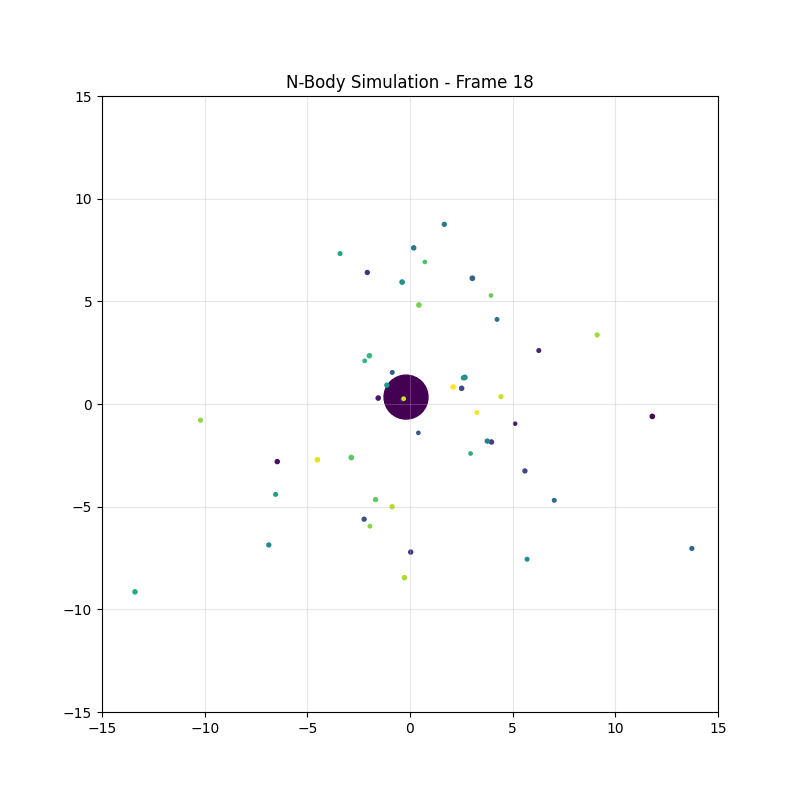
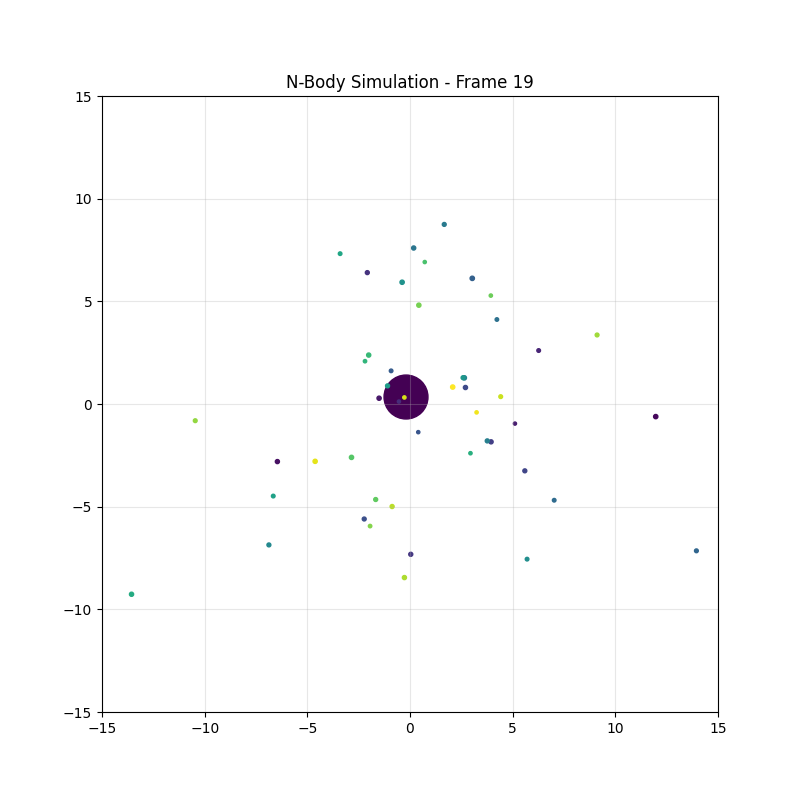
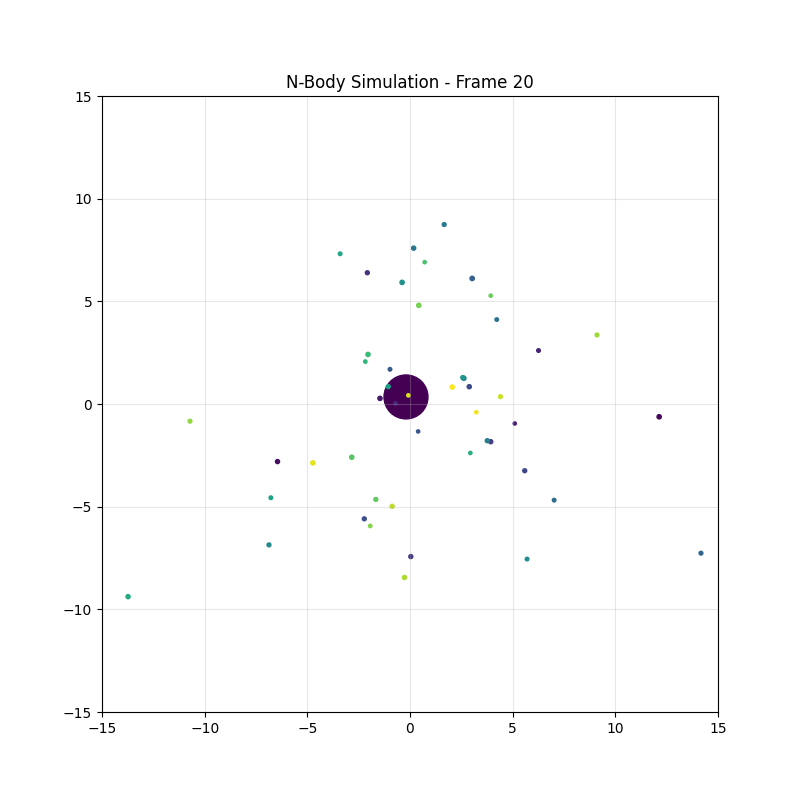
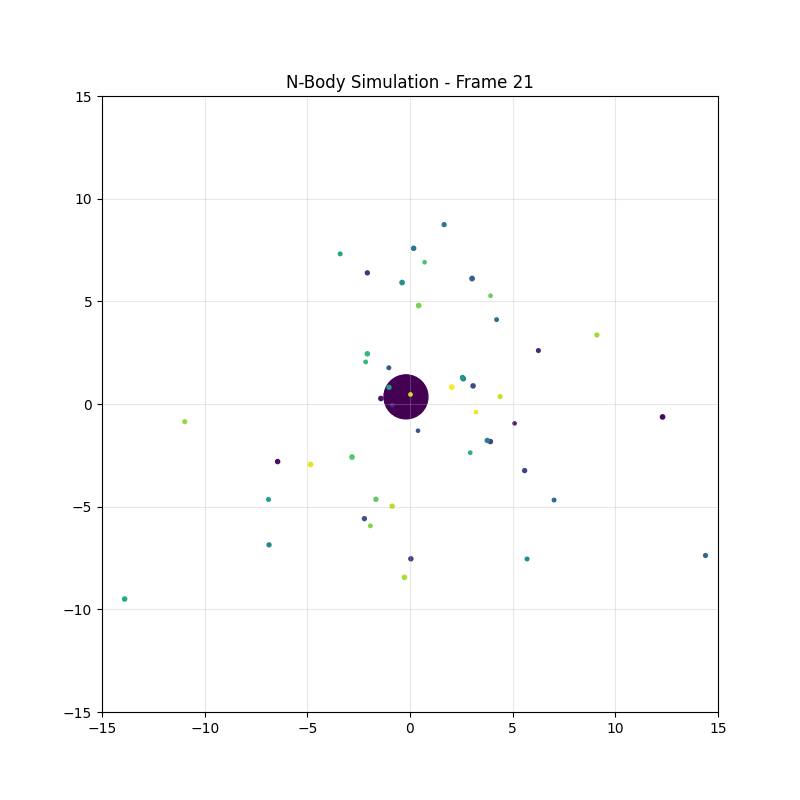
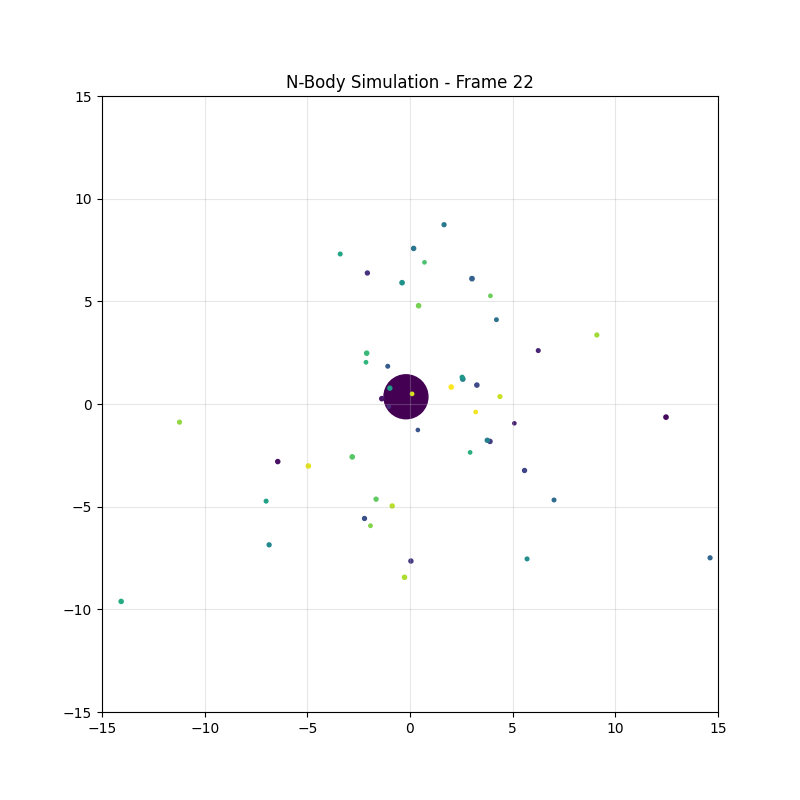
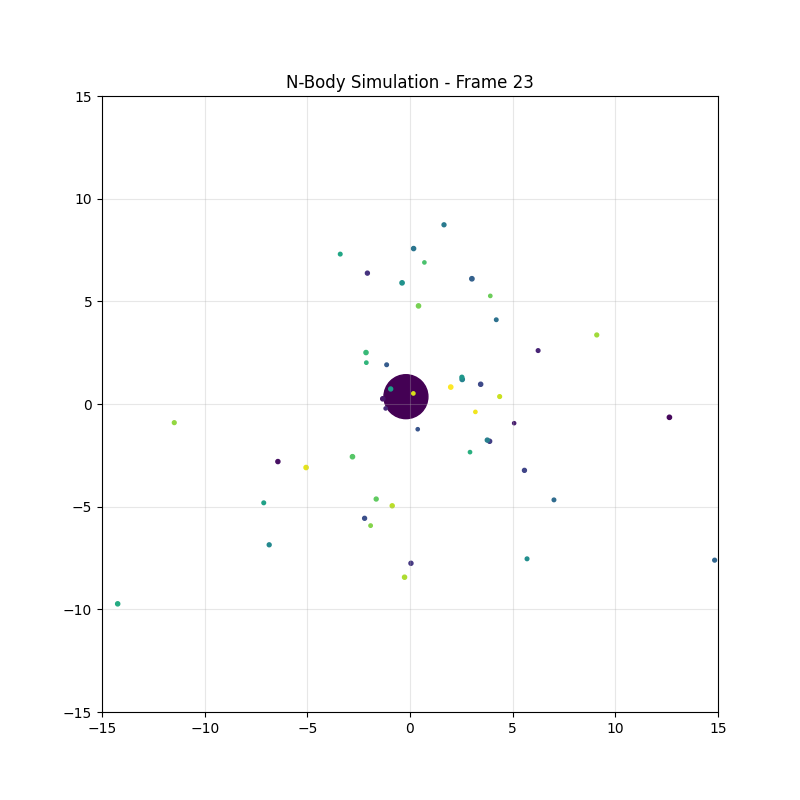
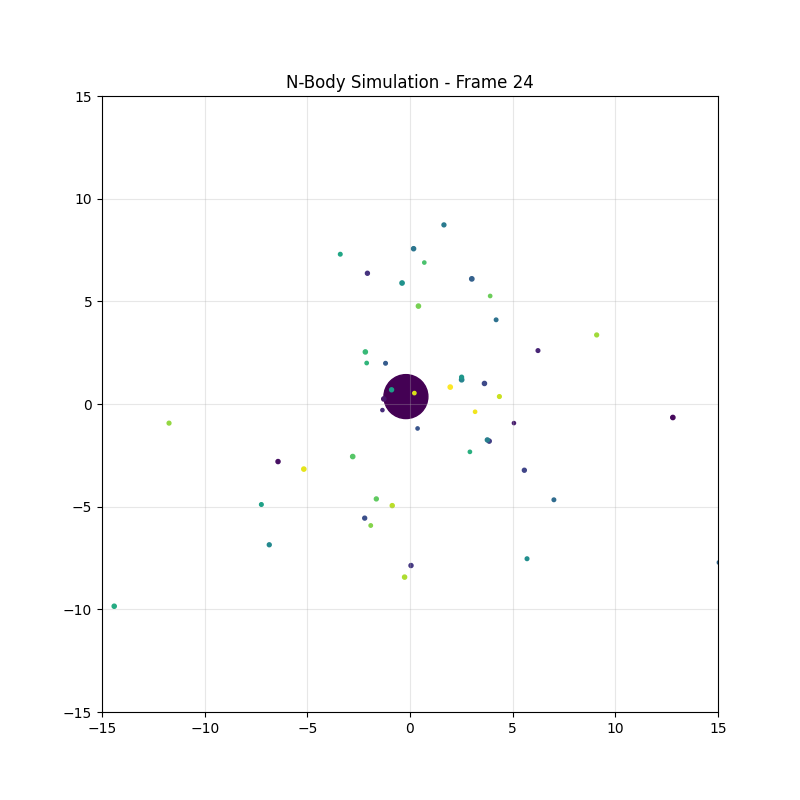
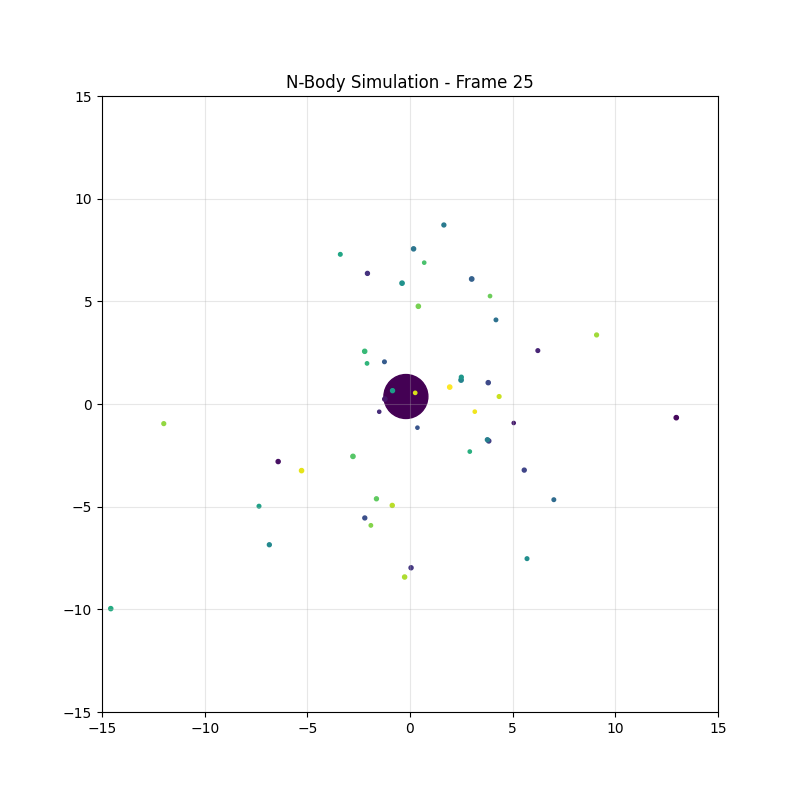
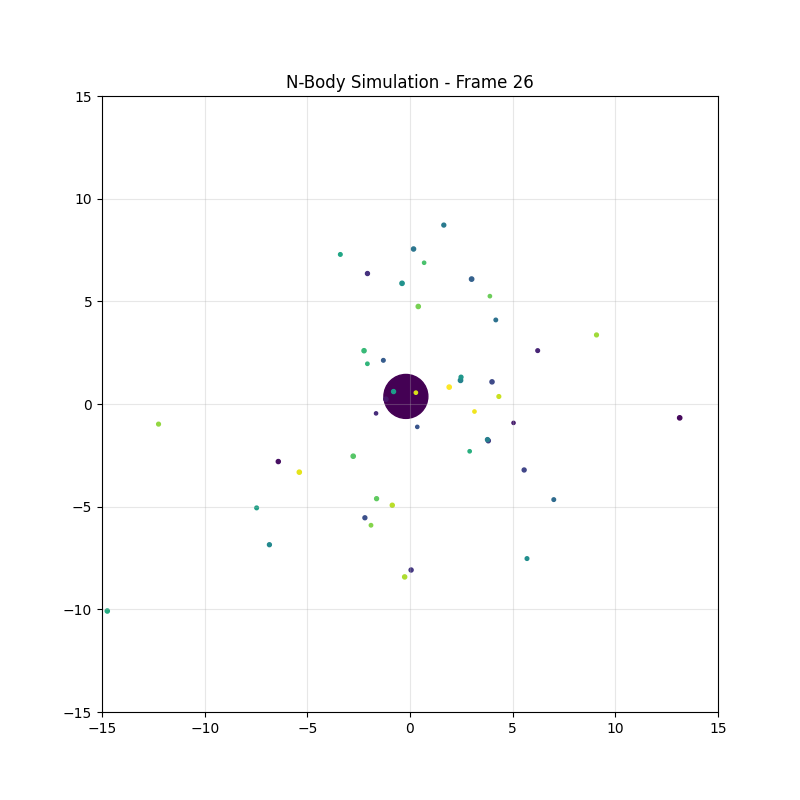
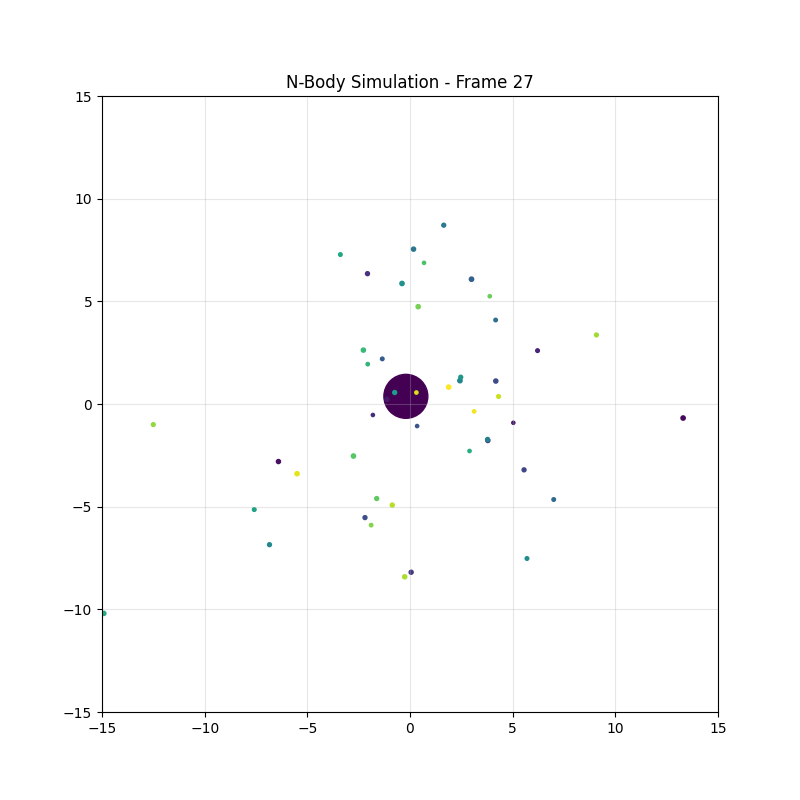
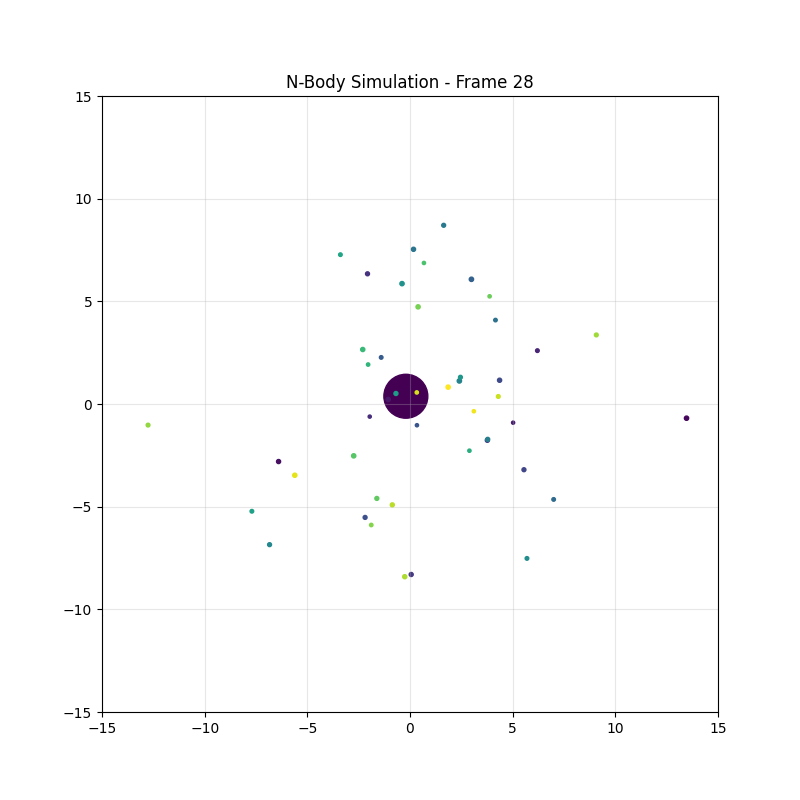
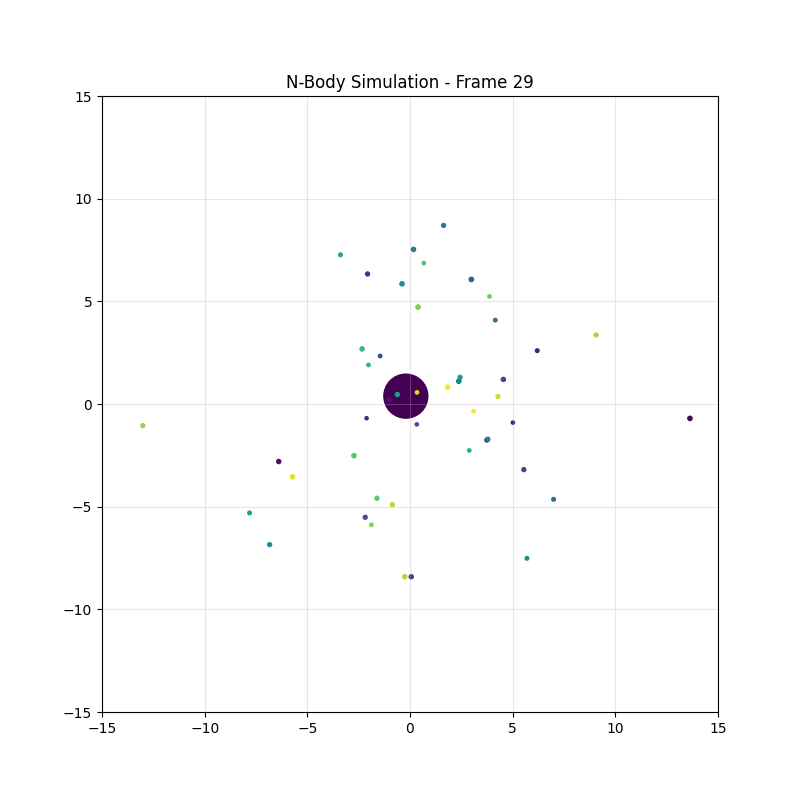
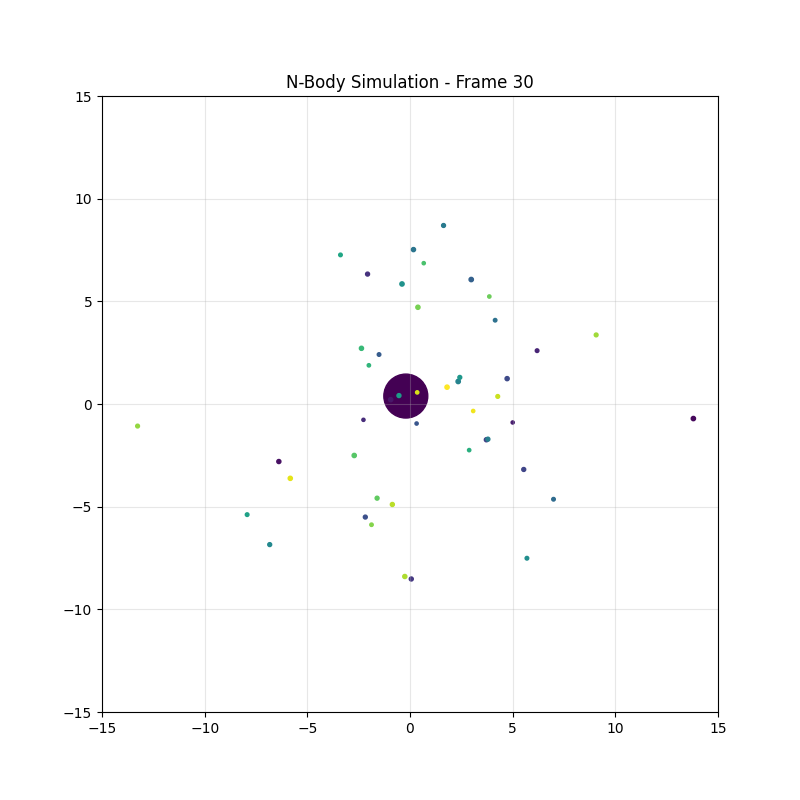
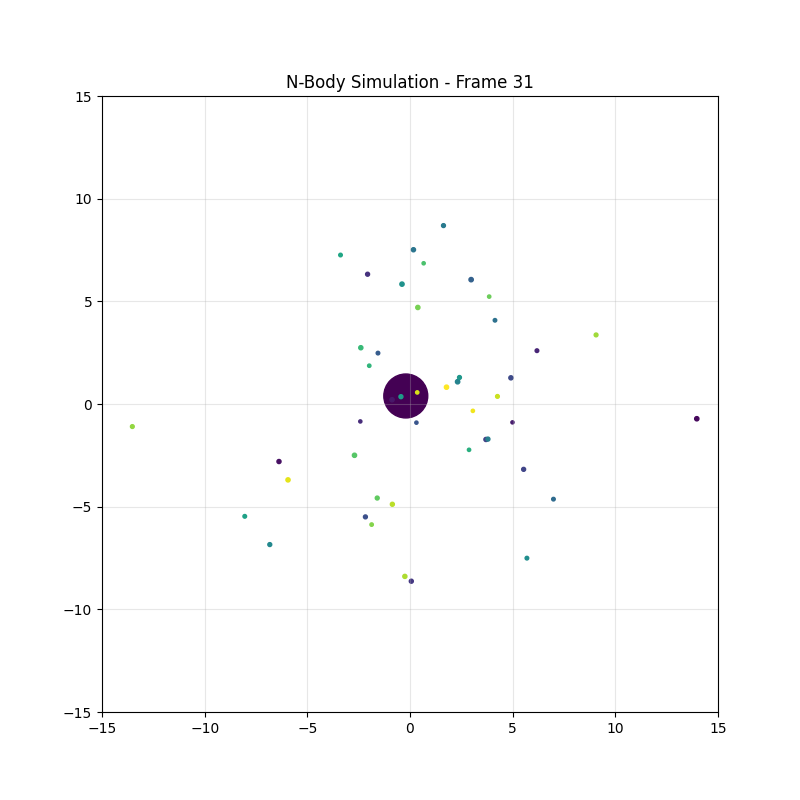
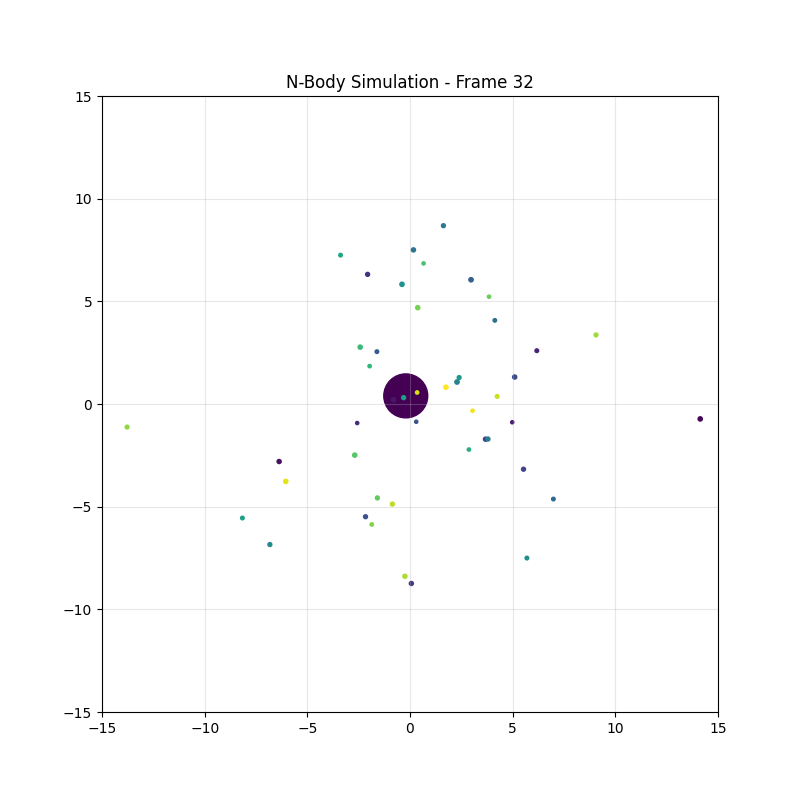
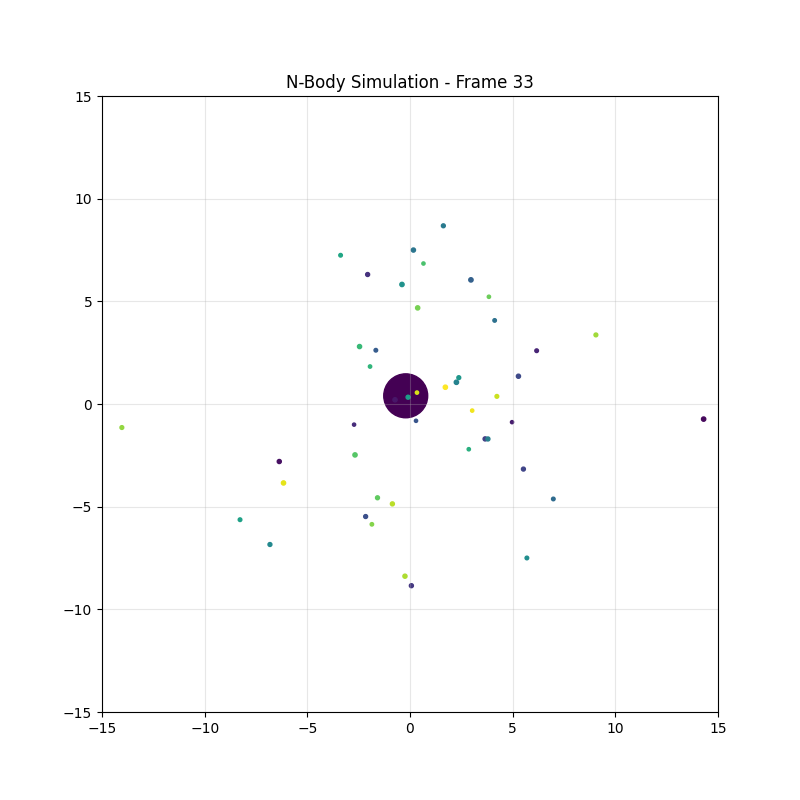
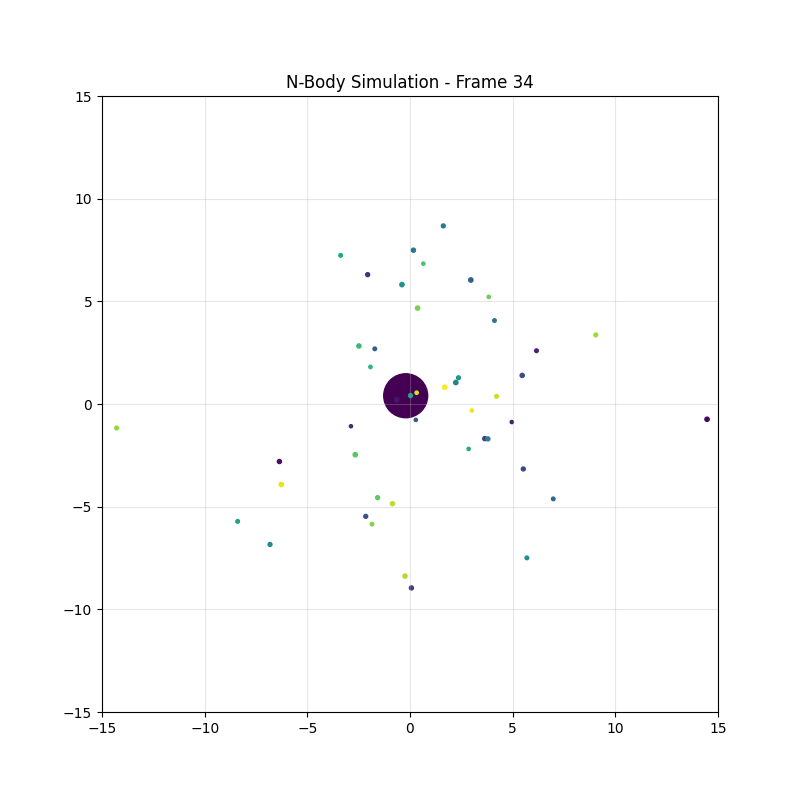
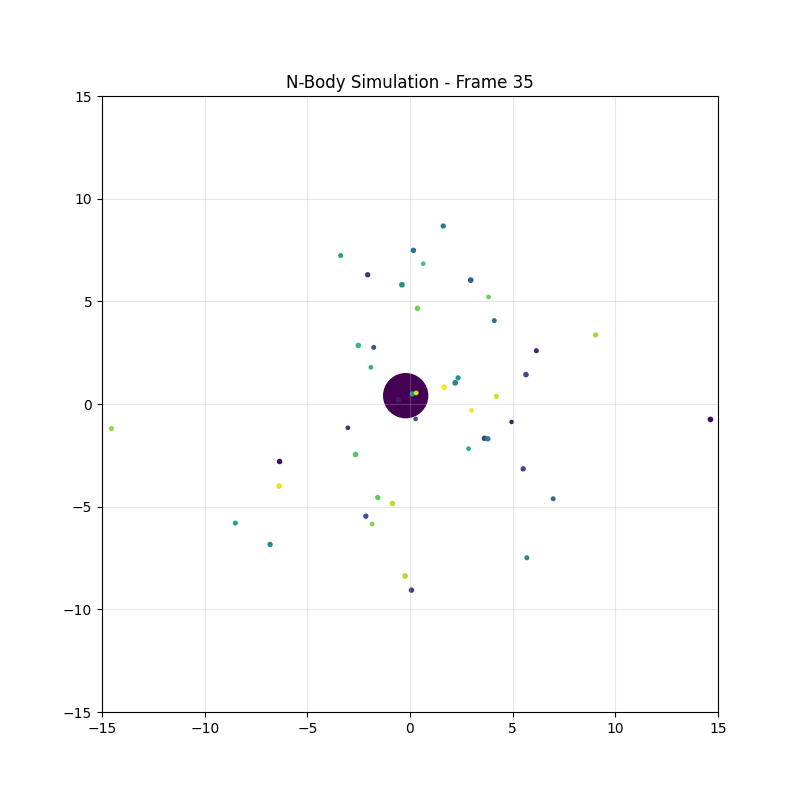
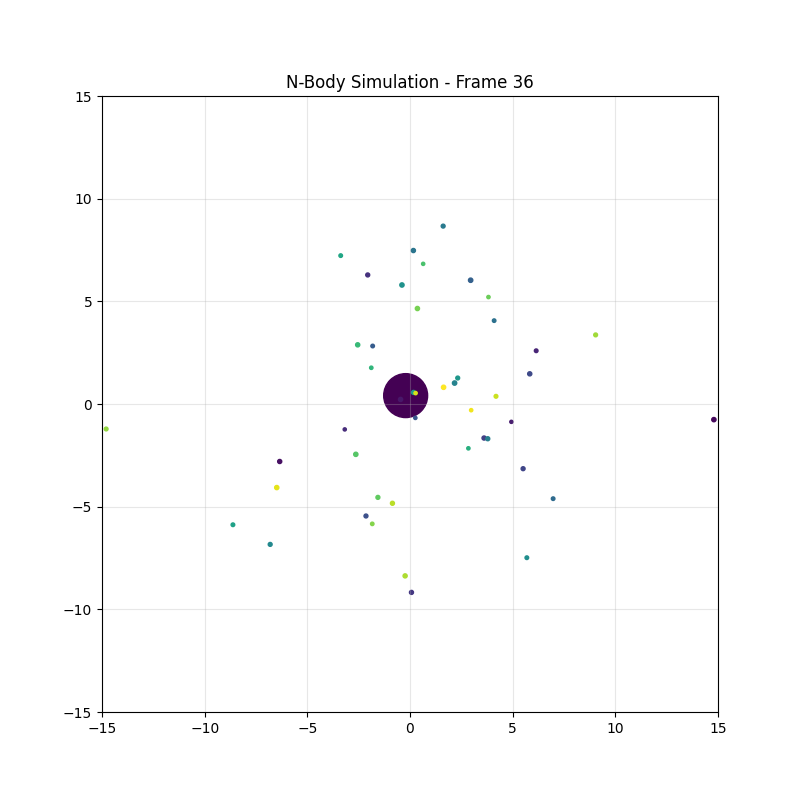
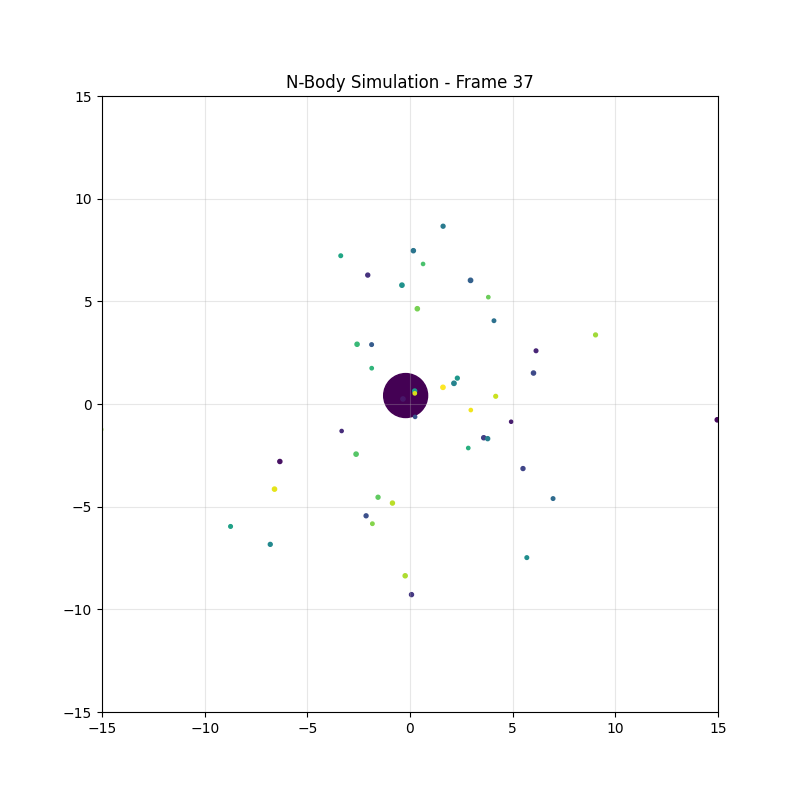
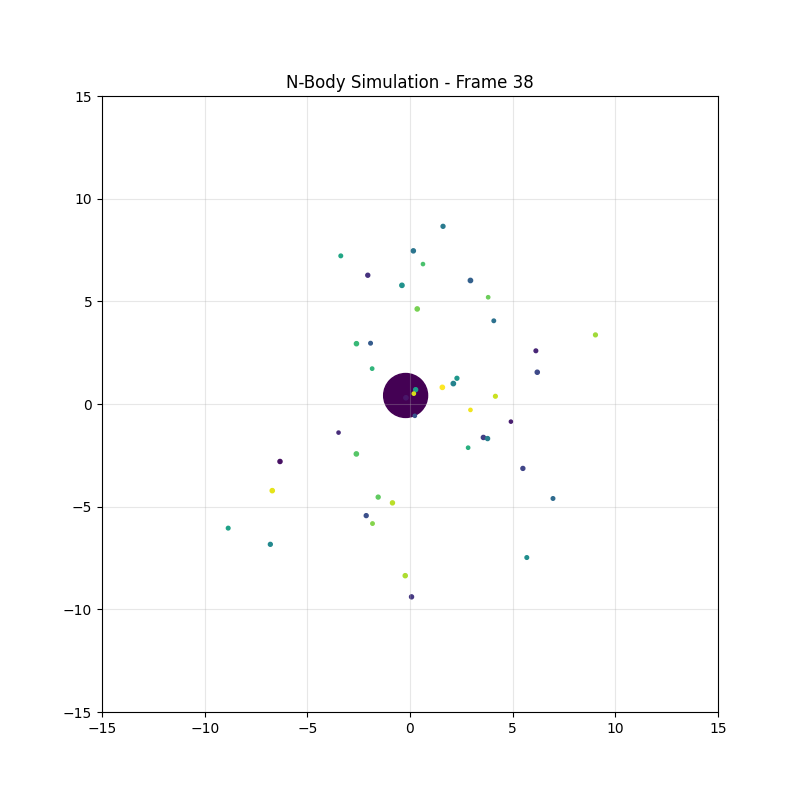
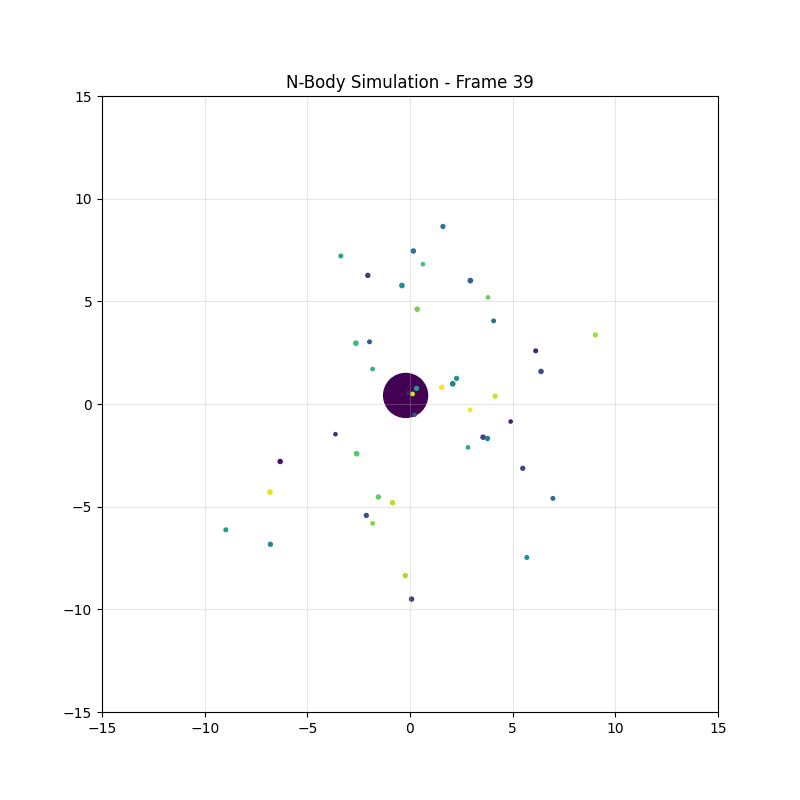
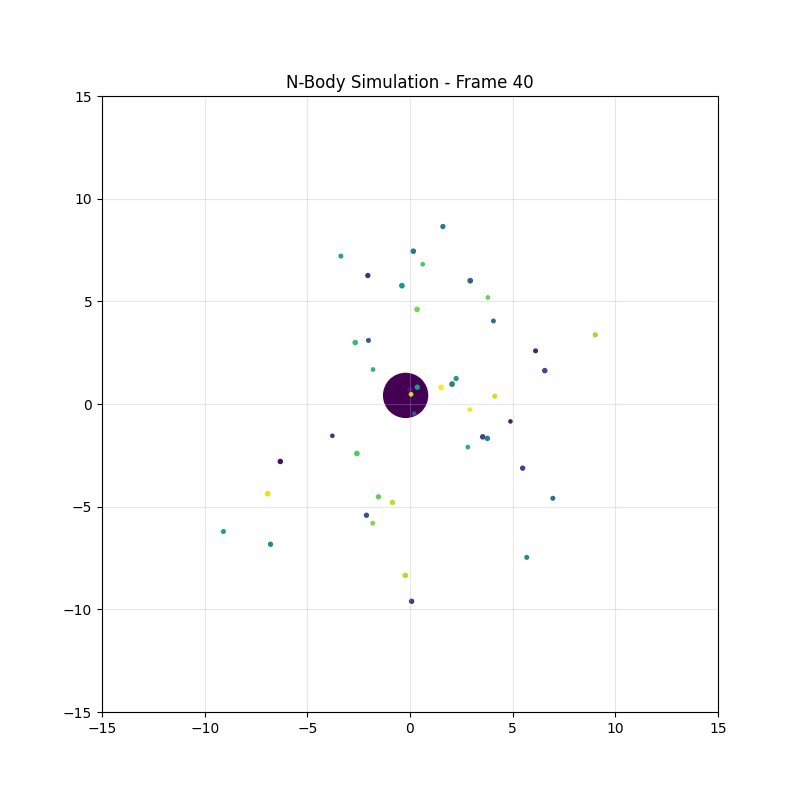
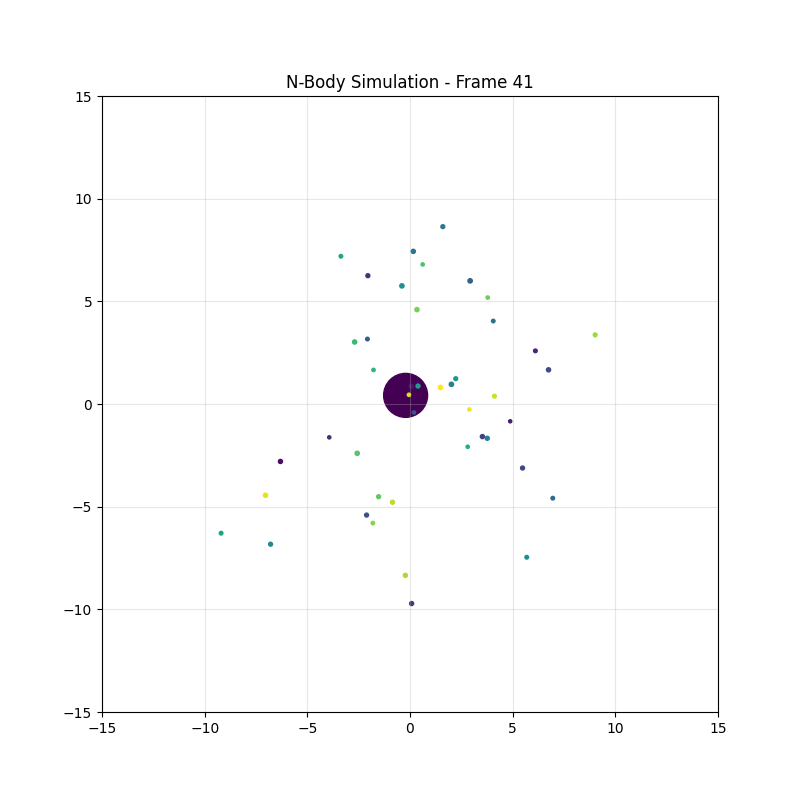
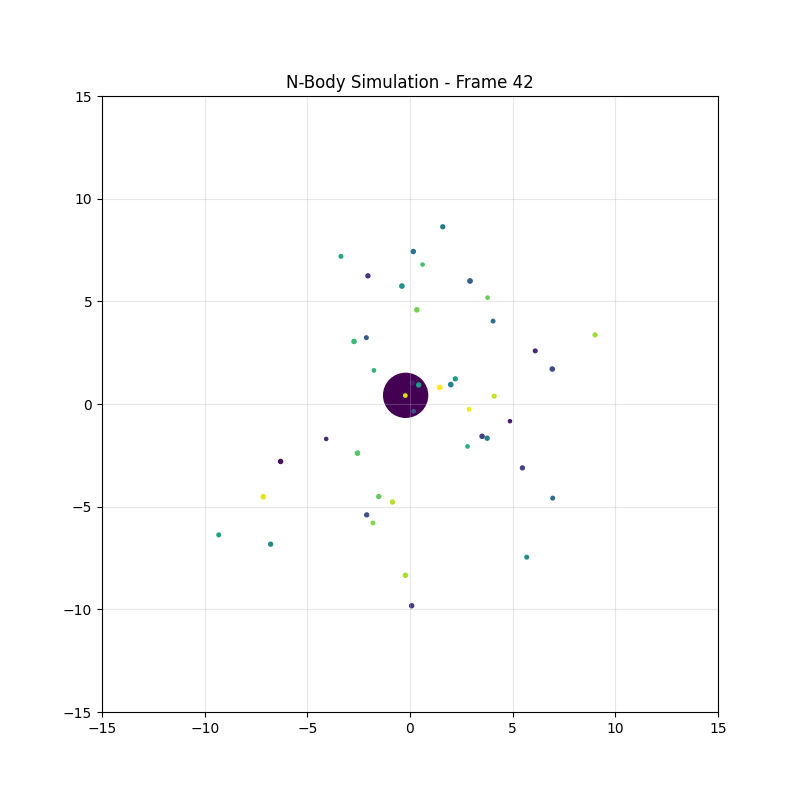
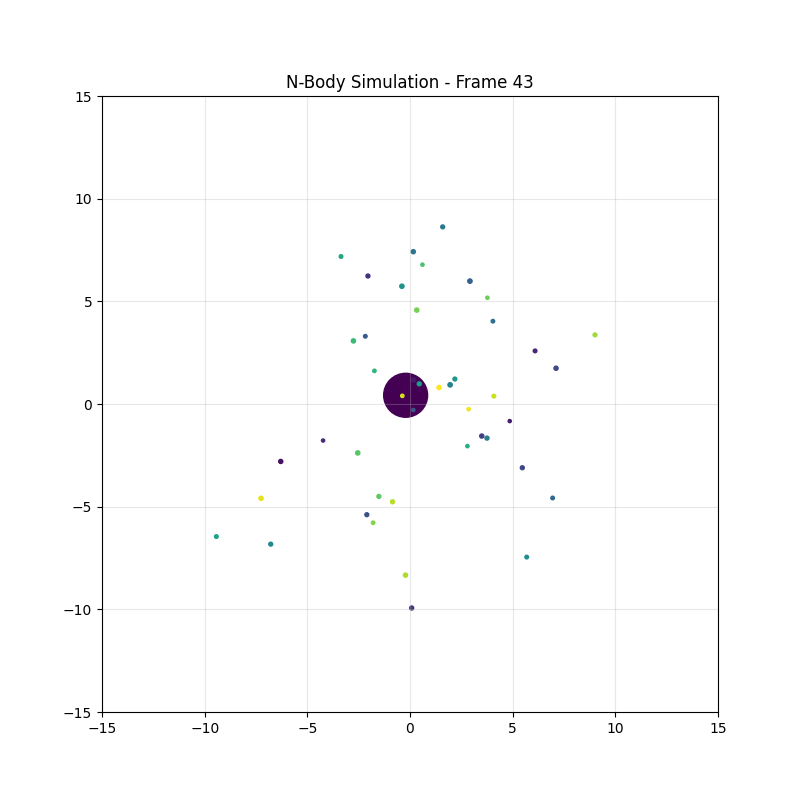
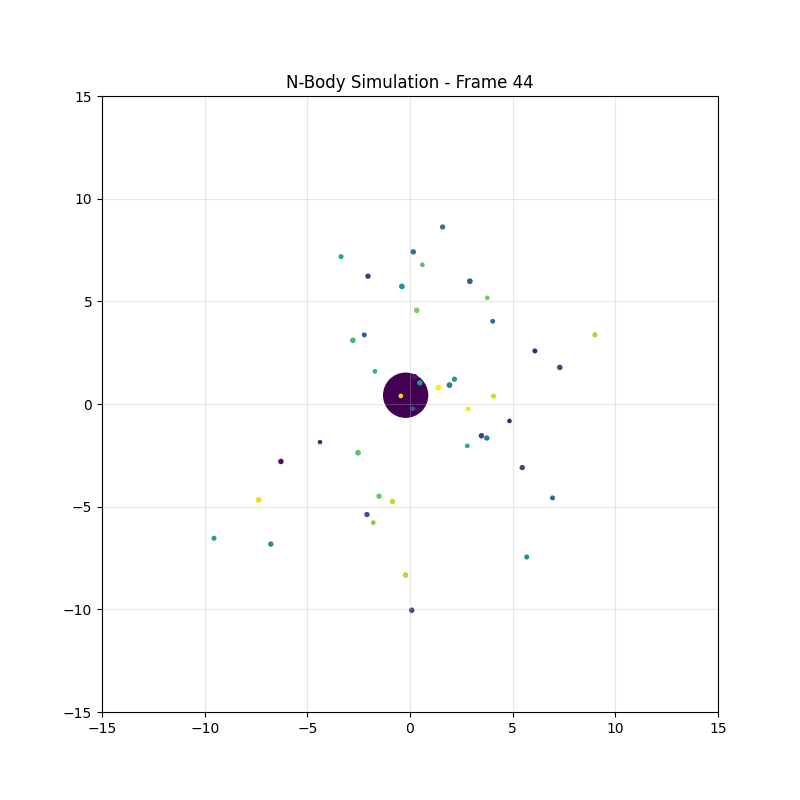
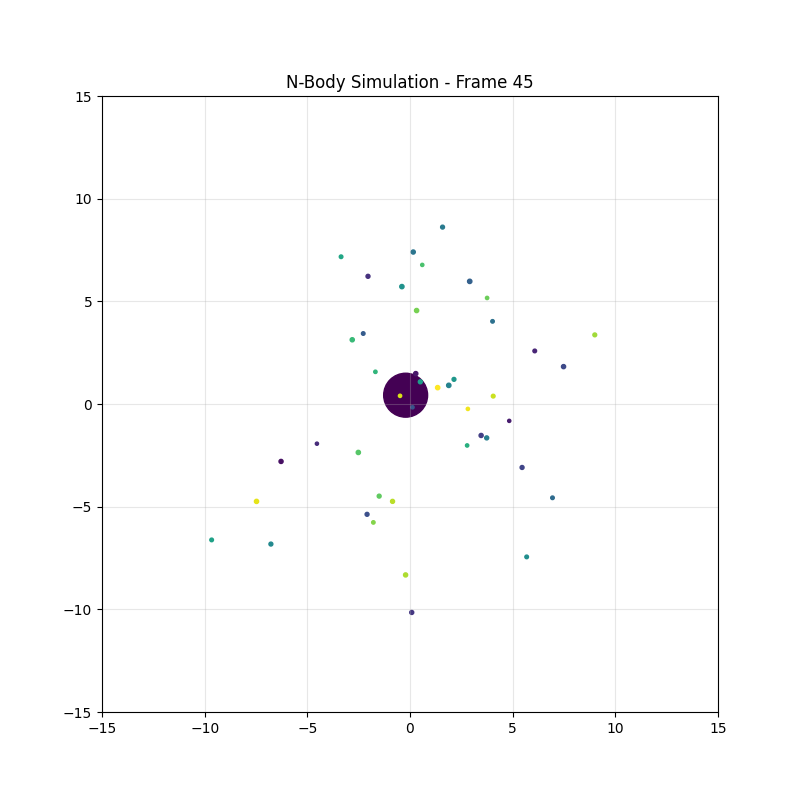
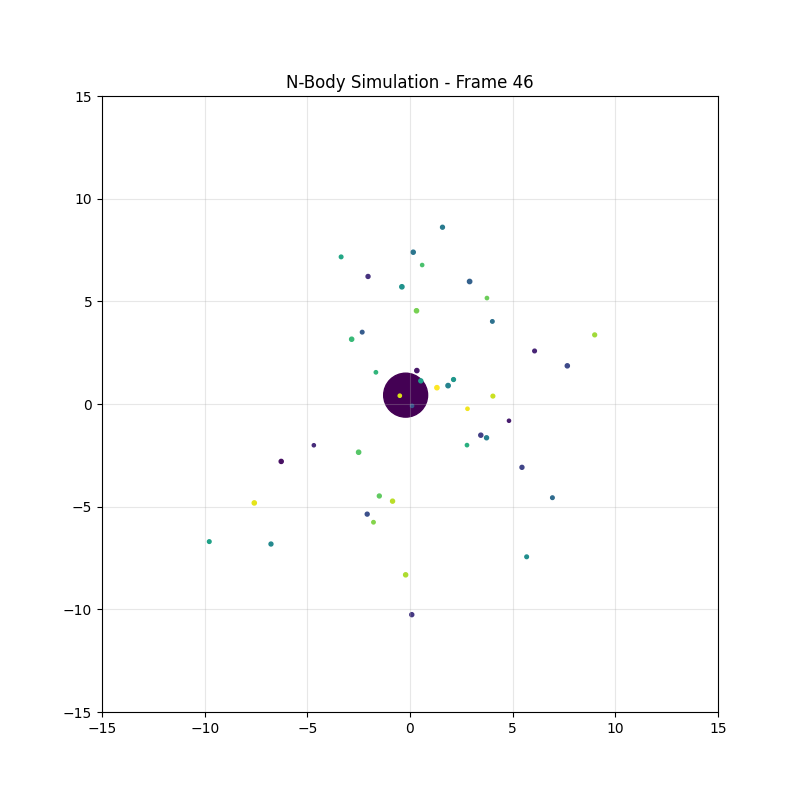
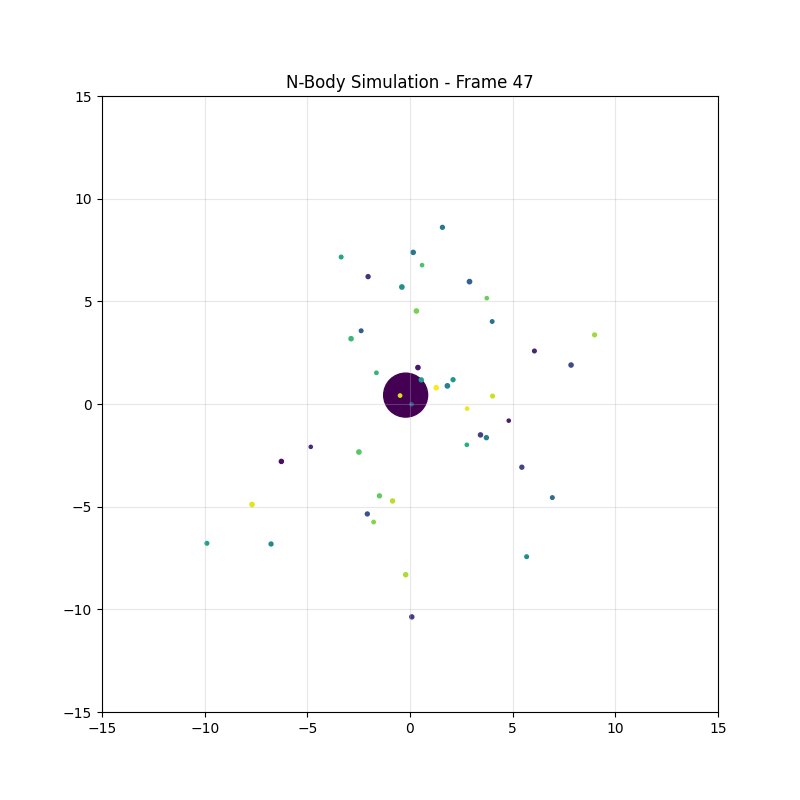
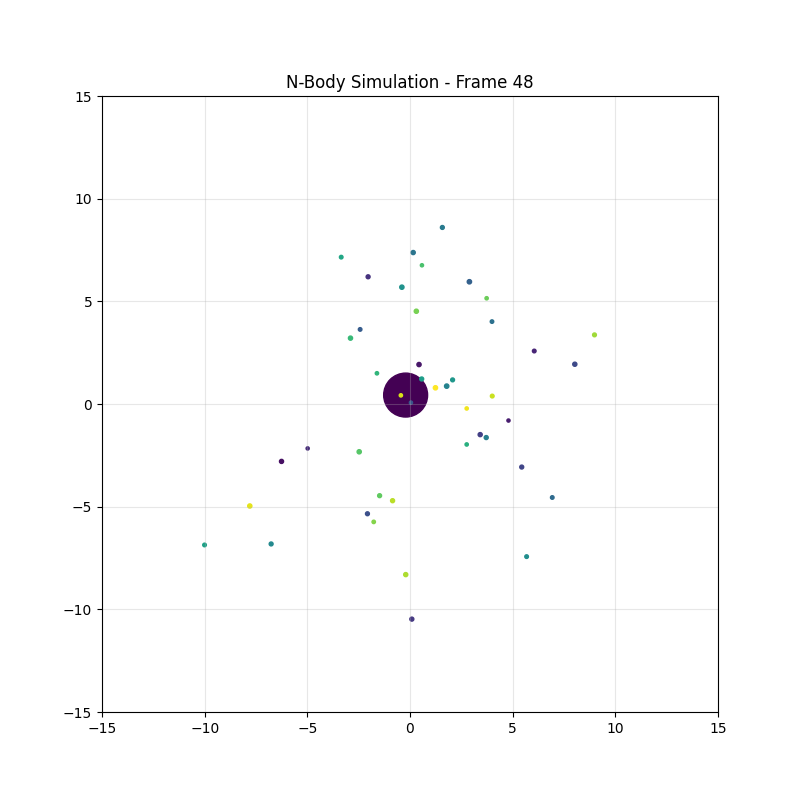
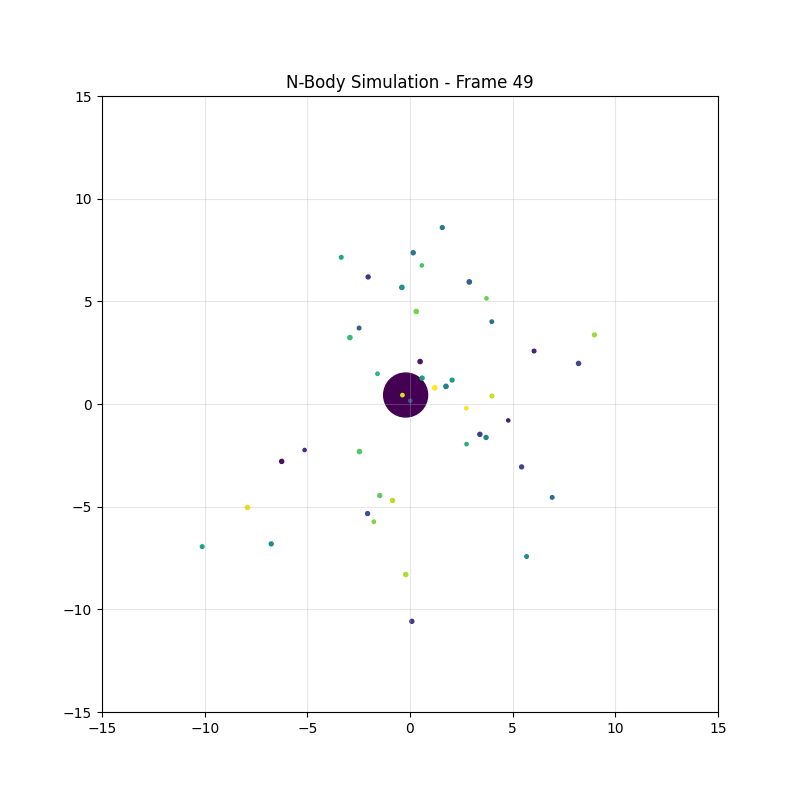
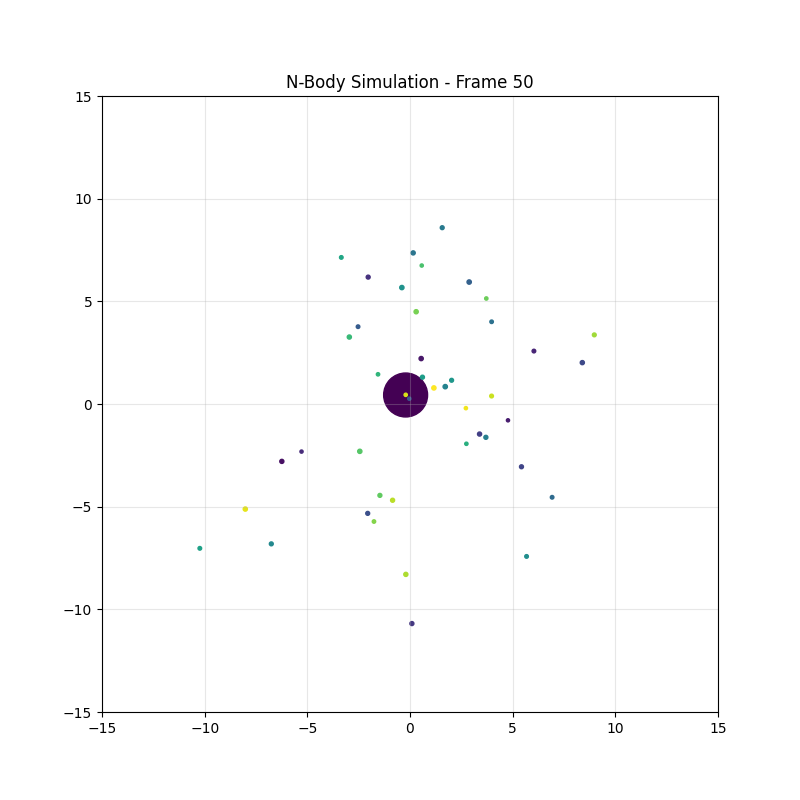

In [4]:
# Compare performance
def compare_performance(n_bodies_list=[50, 100, 200, 500], steps=100):
    """Compare performance between regular and Numba implementations"""
    regular_times = []
    numba_times = []

    for n in n_bodies_list:
        print(f"\nTesting with {n} bodies:")

        # Regular implementation
        print("Regular Python:")
        simulator = NBodySimulator(n_bodies=n, use_numba=False)
        reg_time = simulator.simulate(steps=steps)
        regular_times.append(reg_time)

        # Numba implementation
        print("Numba-optimized:")
        simulator = NBodySimulator(n_bodies=n, use_numba=True)
        # First run includes compilation time
        _ = simulator.simulate(steps=5)
        # Measure actual performance (excluding compilation)
        numba_time = simulator.simulate(steps=steps)
        numba_times.append(numba_time)

        print(f"Speedup: {reg_time/numba_time:.2f}x")

    # Plot results
    plt.figure(figsize=(10, 6))
    width = 0.35
    x = np.arange(len(n_bodies_list))

    plt.bar(x - width/2, regular_times, width, label='Regular Python')
    plt.bar(x + width/2, numba_times, width, label='Numba')

    plt.xlabel('Number of Bodies')
    plt.ylabel('Average Time per Step (seconds)')
    plt.title('Performance Comparison: Regular Python vs Numba')
    plt.xticks(x, n_bodies_list)
    plt.yscale('log')  # Log scale for better visualization
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return regular_times, numba_times

# Run a simulation and create animation
def run_simulation_with_animation(n_bodies=50, simulation_steps=100, animation_frames=50, use_numba=True):
    """Run an N-body simulation and create an animation of the results"""
    # Create simulator
    print(f"Creating simulator with {n_bodies} bodies")
    simulator = NBodySimulator(n_bodies=n_bodies, use_numba=use_numba)

    # Run simulation
    print(f"Running simulation for {simulation_steps} steps")
    simulator.simulate(steps=simulation_steps)

    # Create static visualization
    print("Creating static visualization")
    simulator.visualize_static()

    # Create animation
    print(f"Creating animation with {animation_frames} frames")
    print("This may take a moment...")
    animation = create_simple_animation(simulator, frames=animation_frames)

    return animation

# Run a demonstration
# Uncomment the following line to run:
animation = run_simulation_with_animation(n_bodies=50, simulation_steps=100, animation_frames=50)
animation